<a name="Ho"></a>
# Calling archaic fragments in HGDP

## Contents

1. [ Library and packages ](#Lib)
2. [ Obtaining weight, mutation rate and observation files ](#Obt)
    - 2.1. [ weight file ](#Wei)
        - 2.1.1 accessibility mask
        - 2.1.2 Repetitive regions
        - 2.1.3 Intersecting repetitive regions and accessibility mask
        - 2.1.4 Windowing the genome and annotationg the callability per window
    - 2.2. [ mutation rate file and observation file ](#Mut)
        - 2.2.1 SNP filtering
            - 2.2.1.1 Biallelic SNPs
            - 2.2.1.2 SNPs in callalble regions
        - 2.2.2 Genotypes in the outgroup
        - 2.2.3 Polarize alleles and SNP filtering for ancestral allele called
        - 2.2.4 Polymorphic sites in the outgroup and mutation rate file
        - 2.2.5 Observation file for one individual
3. [ Training and Decoding ](#Hmm)


## To Do

1. When determining if a loci is polymorphic in the outgroup to compute mutation rate, Skov et al doesn't take into account fixed derived alleles.
2. Determine correctly biallelic loci.
3. Add other African data.

<a name="Lib"></a>
## 1. Library and packages


In [8]:
from collections import defaultdict
import sys
import gzip
import time
import numpy as np
import pandas as pd
import allel
import zarr
import numcodecs
import time
import math
# import plotly.graph_objs as go
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
%%R

library(tidyverse)
library(cowplot)
library(ggrepel)
library("rnaturalearth")
library("rnaturalearthdata")
library("ggplot2")
library("sf")
theme_set(theme_light())

[<img src="notebooks_files/arrow.png" width="100" style="float: left;">](#Ho) &nbsp;

&nbsp;

<a name="Int"></a>
## 2. Introduction to Skov et al method

Laurits did a tutorial in order to run his model (https://github.com/LauritsSkov/Introgression-detection) to find archaic (Neanderthal and Denisova, or even more archaic humans) fragments in non-African individual genomes. In short, the method consists of a hidden Markov model which is going to classify the ancestry of the windows (usually of 1kb) of the genome in either Archaic or nonArchaic. For that, the model assumes that a sister group to the target non-African genome will share most of the nonArchaic variation with the sample; in our case, this group are SubSaharanAfricans. Thus, by removing all the shared variation there will be a big contrast between windows of nonArchaic and Archaic ancestry: the nonArchaic ancestry windows will have small amouts of genetic variation corresponding to mutations accumulated since the split between Africans and non-Africans, while the ones of Archaic ancestry will have much more genetic variation that had been accumulating since the split of Archaics and modern humans.

The script to run needs 3 files:

1) **observation file**: 
This file has the number of SNPs called for each window. It consists of 4 columns:

    - 1.1. chromosome: e.g. 1
    - 1.2. window: e.g. 1000
    - 1.3. number of SNPs: e.g. 1
    - 1.4. SNP genomic locations: 1101
   
2) **weight file**: This file contains for each window the proportion of callable bases. It consists of 3 columns:

    - 2.1. chromosome: e.g. 1
    - 2.2. window: e.g. 1000
    - 2.3. callable proportion: e.g. 0.5
    
3) **mutation rate file**: This file contains the ratio between the mutation rate in that window and the mean mutation rate. It consists of 3 columns:

    - 3.1. chromosome: e.g. 1
    - 3.2. window: e.g. 1000
    - 3.3. ratio mutation rate: e.g. 0.5
    
Once we obtained all necessary files we will run two scripts: `Train.py` and `Decode.py`. 

In this notebook I'll obtain all necessary files for chromosome 22 as a toy example. 

[<img src="notebooks_files/arrow.png" width="100" style="float: left;">](#Ho) &nbsp;

&nbsp;

<a name="Obt"></a>
## 2. Obtaining weight, mutation rate and observation files

<a name="Wei"></a>
### 2.1 weight file

### 2.1.1 accessibility mask

The HGDP data provides accessibility mask file:

In [3]:
%%bash

ls /home/moicoll/HGDP/data/accessibility-mask

hgdp_wgs.20190516.mask.bed
README.hgdp_wgs.20190516.mask.txt


In [4]:
%%bash

cat /home/moicoll/HGDP/data/accessibility-mask/README.hgdp_wgs.20190516.mask.txt

The hgdp_wgs.20190516.mask.bed file is a positive mask, meaning it denotes which regions of the genome are accessible, and was constructed as follows:
 - The 1000 Genomes StrictMask accessibility mask was obtained from http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/working/20160622_genome_mask_GRCh38/
 - Subtracted from this were regions on the primary assembly which have alternative loci or patch scaffolds, as specified in this file: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/GCA_000001405.15_GRCh38_assembly_structure/genomic_regions_definitions.txt
 - Subtracted from this were sites that display excessive (p<1e-6) heterozygosity in callset hgdp_wgs.20190516.full (autosomes only)

This leaves 2,252,286,208 bp of sequence, which is approximately 73% of the primary assembly.


This accessibility-mask file is in bed format:

In [5]:
%%bash 

head /home/moicoll/HGDP/data/accessibility-mask/hgdp_wgs.20190516.mask.bed

chr1	55319	55330
chr1	85987	86031
chr1	86327	86345
chr1	87079	87119
chr1	629060	629081
chr1	778561	778562
chr1	778564	778565
chr1	778566	778621
chr1	778740	778765
chr1	779196	779225


### 2.1.2 Repetitive regions

In Laurit's tutorial, he also mentions that he removes all regions which are identified by Repead Masker and Tandem Repeats Finder. To do that, I'll intersect the non-repetitive regions from the accessibility mask file from above. However, we don't have directly a bed file. Thus, I'll first get the coordinates of the non-repetitive regions from the reference genome (GRCh38 fasta file) and format them in bed. 

I downloaded the reference genome (GRCh38) from https://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/ where the following is stated:

*Repeats from RepeatMasker and Tandem Repeats Finder (with period of 12 or less) are shown in lower case; non-repeating sequence is shown in upper case.*

However, Laurit's was based on a file formated sliglty different:

*hg38.fa.masked.gz - "Hard-masked" assembly sequence in one file. Repeats are masked by capital Ns; non-repeating sequence is shown in upper case.*

Which means that we can identify non-repeatitive regions by scanning the fasta files in that directory (for every chromosome) and annotate the positions that are either to the callable nucleotides ("A", "C", "T", "G"), similarly to Laurit's tutorial. 

To make sure I code the coordinates in bed format correctly, let's look up the specifics of the bed format. From https://software.broadinstitute.org/software/igv/BED we have the following explanation on how the bed file coordinates are indicated:

*Zero-based index: Start and end positions are identified using a zero-based index. The end position is excluded. For example, setting start-end to 1-2 describes exactly one base, the second base in the sequence.*

So, let's give an example:

From the explanation above, if we wanted to indicate the first base pair, we do it as follows:

Since we want to identify the non-repetitive regions (consecutive sequences of "A", "C", "T" and "G") the way to indicate them from the previous example we do it this way:

In [6]:
i       = 0
callabl = False

line = "NNNACTNNNACTNNNA"

for c in line: #For each character in the line
    if c in ["A", "C", "T", "G"] and not callabl:
        start = i
        callabl = True
    if c not in ["A", "C", "T", "G"] and callabl:
        print("{}\t{}\t{}".format("22", start, i))
        callabl = False
    i += 1
    
if callabl:
    print("{}\t{}\t{}".format("22", start, i))

22	3	6
22	9	12
22	15	16


From the chunck above, we can see that we can extract the regions correctly. Then, I'll adapt the code to run in the original chr22 reference genome fasta.

In [7]:
out = open("/home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_nonrep.txt", "w")

i       = 0
callabl = False

with gzip.open("/home/moicoll/GenerationInterval/data/GRCh38/chr22.fa.gz", "r") as file:
    for bline in file: 
        line = bline.decode("utf-8").strip()
        if line[0] != ">":       
            for c in line: #For each character in the line
                if c in ["A", "C", "T", "G"] and not callabl:
                    start = i
                    callabl = True
                if c not in ["A", "C", "T", "G"] and callabl:
                    out.write("{}\t{}\t{}\n".format("chr22", start, i))
                    callabl = False
                i += 1    
if callabl:
    out.write("{}\t{}\t{}\n".format("chr22", start, i))

out.close()

to check a region from the fasta file as example, I'll use `samtools faidx`. To see how the indexing for this tool works, I'll also use a toy example

In [8]:
%%bash

echo ">moi" > moi.fa
echo "0123456789" >> moi.fa

cat moi.fa

samtools faidx moi.fa moi:1-1
samtools faidx moi.fa moi:5-8
samtools faidx moi.fa moi:1-10

rm moi.fa moi.fa.fai

>moi
0123456789
>moi:1-1
0
>moi:5-8
4567
>moi:1-10
0123456789


For this tool, the indexing works different compared to bedtools. From the previous example, we get that it's a 1-based indexing including the end position. 

So, form the example we've been playing with so far, if we want to examin the repetitive sequneces we must get the bed format and:

In [9]:
%%bash

echo ">22" > moi.fa
echo "NNNACTNNNACTNNNA" >> moi.fa

cat moi.fa

#22 3 6
samtools faidx moi.fa 22:4-6
#22 9 12
samtools faidx moi.fa 22:10-12
#22 15 16
samtools faidx moi.fa 22:16-16



rm moi.fa moi.fa.fai

>22
NNNACTNNNACTNNNA
>22:4-6
ACT
>22:10-12
ACT
>22:16-16
A


Some of the repetitive regions that I anotated are:

In [10]:
%%bash

head /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_nonrep.txt

chr22	10510000	10510227
chr22	10510528	10511018
chr22	10511332	10511479
chr22	10511791	10511878
chr22	10512212	10512454
chr22	10512692	10512706
chr22	10516103	10516114
chr22	10516285	10516287
chr22	10516630	10516635
chr22	10517247	10517290


In order to explore the fasta file, I'm going to unzip it and check some of the regions heads and tails. Further, I'm going to include and extra base pair from each end which is expected to be different than a callable base pair (A, C, T or G).

In [11]:
%%bash

zcat /home/moicoll/GenerationInterval/data/GRCh38/chr22.fa.gz > chr22.fa

samtools faidx chr22.fa chr22:10510000-10510228 | head -n 2
samtools faidx chr22.fa chr22:10510000-10510228 | tail -n 1
echo ""
samtools faidx chr22.fa chr22:10511332-10511480 | head -n 2
samtools faidx chr22.fa chr22:10511332-10511480 | tail -n 1
echo ""
samtools faidx chr22.fa chr22:10516630-10516636 | head -n 2
samtools faidx chr22.fa chr22:10516630-10516636 | tail -n 1
    
rm chr22.fa chr22.fa.fai

>chr22:10510000-10510228
NGAATTCTTGTGTTTATATAATAAGATGTCCTATAATTTCTGTTTGGAATATAAAATCAG
ATTATATTAAAAGGTTTCATCAGTAATTCATTATATCAAAATGCTCCAg

>chr22:10511332-10511480
aAAACTTATTTCCCATAATAAAAATTTTAAGTTTTTGTAAGTAAATGATAAATAATAATT
AAGGAGCCCAGTTTAAAATTCCTGTCAGg

>chr22:10516630-10516636
tTAATTa
tTAATTa


Thus, the transformation form fasta to bed format of the callable regions has been correctly done.

### 2.1.3 Intersecting repetitive regions and accessibility mask

Now, we can remove the repetitive regions from the accessibility mask regions with bedtools with the following command.

In [12]:
%%bash

bedtools intersect -a /home/moicoll/HGDP/data/accessibility-mask/hgdp_wgs.20190516.mask.bed -b /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_nonrep.txt > /home/moicoll/GenerationInterval/people/moi/tmp/call/chr22_call.txt

head /home/moicoll/GenerationInterval/people/moi/tmp/call/chr22_call.txt 

chr22	10661594	10661617
chr22	10669343	10669375
chr22	10669382	10669383
chr22	10680028	10680057
chr22	10690633	10690654
chr22	10698602	10698606
chr22	10961562	10961662
chr22	11253312	11253348
chr22	11437343	11437344
chr22	11606003	11606021


Then, we can check how much is removed once both bed files are used:

In [13]:
%%bash
echo "accessibility mask"
egrep "chr22" /home/moicoll/HGDP/data/accessibility-mask/hgdp_wgs.20190516.mask.bed | head
egrep "chr22" /home/moicoll/HGDP/data/accessibility-mask/hgdp_wgs.20190516.mask.bed \
    | awk '{sum += $3-$2}END{print "total length\t"sum}'
echo "non-repetitive"
awk '{if($2 > 10661000){print}}' /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_nonrep.txt | head
awk '{if($2 > 10661000){print}}' /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_nonrep.txt \
    | awk '{sum += $3-$2}END{print "total length\t"sum}'
echo "intersect"
head /home/moicoll/GenerationInterval/people/moi/tmp/call/chr22_call.txt
awk '{sum += $3-$2}END{print "total length\t"sum}' /home/moicoll/GenerationInterval/people/moi/tmp/call/chr22_call.txt

accessibility mask
chr22	10661594	10661617
chr22	10666327	10666383
chr22	10666974	10666975
chr22	10669343	10669375
chr22	10669382	10669383
chr22	10680028	10680057
chr22	10690633	10690654
chr22	10691177	10691186
chr22	10691670	10691675
chr22	10691811	10691818
total length	24432949
non-repetitive
chr22	10661117	10661497
chr22	10661562	10661729
chr22	10661851	10661967
chr22	10662277	10662376
chr22	10662428	10662462
chr22	10662679	10662795
chr22	10662878	10662905
chr22	10664084	10664278
chr22	10664586	10665250
chr22	10665374	10665447
total length	18130978
intersect
chr22	10661594	10661617
chr22	10669343	10669375
chr22	10669382	10669383
chr22	10680028	10680057
chr22	10690633	10690654
chr22	10698602	10698606
chr22	10961562	10961662
chr22	11253312	11253348
chr22	11437343	11437344
chr22	11606003	11606021
total length	14832113


In [14]:
print("{}\t{}\n{}\t{}".format("proportion intersect/accessibility mask", 14832113/24432949, "proportion intersect/non-repetitive", 14832113/18130978))


proportion intersect/accessibility mask	0.6070537371481437
proportion intersect/non-repetitive	0.8180536648381571


So, we see that we are left with 60% of the original accessibility mask. Since the accessibility mask was already a 70% of the whole genome, this means that only 40% of the whole genome would remain. These numbers are orientative since it's only for chromosome 22. 

### 2.1.4 Windowing the genome and annotationg the callability per window

In the next chunk, I divide a given chromosome into windows of certain length (1kb) and output all the windows in a bed format using pandas and numpy.

In [3]:
chrlen = {"chr1"  : 249250621, "chr2"  : 243199373, "chr3"  : 198022430, "chr4"  : 191154276, "chr5"  : 180915260, 
          "chr6"  : 171115067, "chr7"  : 159138663, "chr8"  : 146364022, "chr9"  : 141213431, "chr10" : 135534747, 
          "chr11" : 135006516, "chr12" : 133851895, "chr13" : 115169878, "chr14" : 107349540, "chr15" : 102531392, 
          "chr16" :  90354753, "chr17" :  81195210, "chr18" :  78077248, "chr19" :  59128983, "chr20" :  63025520, 
          "chr21" :  48129895, "chr22" :  51304566, "chrX"  : 155270560, "chrY"  :  59373566, "chrM"  :     16571}

chrom  = "chr22"
window = 1000
end    = chrlen[chrom] + window if chrlen[chrom] % window else chrlen[chrom]

pd.DataFrame({"chrom" : np.array([chrom]*((end//window)+1)),
              "start" : np.arange(0, end, window),
              "end"   : np.arange(window, end+window, window)}).to_csv("/home/moicoll/GenerationInterval/people/moi/tmp/weigths/{}_windows.txt".format(chrom), sep = "\t", header=False, index=False)

Then, by using that file, I figure out the proportion of callable (accessible and non repetitive) bases there are in each window with bedtools. The output must be processed because if a window has multiple hits with multiple accessible regions, we are going to get an entry for each hit. Thus, I must add up all the hits and output a single entry for each chromosomal window. 

In [16]:
%%bash

bedtools intersect -wao -a /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_windows.txt \
                        -b /home/moicoll/GenerationInterval/people/moi/tmp/call/chr22_call.txt \
 | awk 'BEGIN{chrom = 0}{if(chrom != 0){
                              if(start != $2){
                                  print chrom"\t"start"\t"end"\t"overlap/1000; 
                                  chrom = $1; start = $2; end = $3; overlap = $7
                                              }
                              else{
                                  overlap = overlap+$7
                                  }
                                       }
                          else{chrom = $1; start = $2; end = $3; overlap = $7}}
        END{print chrom"\t"start"\t"end"\t"overlap/1000}' > /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_weigths.txt

head -n 3 /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_weigths.txt
head -n 50000 /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_weigths.txt | tail -n 3
tail -n 3 /home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_weigths.txt

chr22	0	1000	0
chr22	1000	2000	0
chr22	2000	3000	0
chr22	49997000	49998000	0.963
chr22	49998000	49999000	0.474
chr22	49999000	50000000	0.528
chr22	51303000	51304000	0
chr22	51304000	51305000	0
chr22	51305000	51306000	0


[<img src="notebooks_files/arrow.png" width="100" style="float: left;">](#Ho) &nbsp;

&nbsp;


<a name="Mut"></a>

### 2.2 mutation rate file and observation file

The mutation rate file indicates the proportion of segregating sites in the optgroup in windows of 1kb per chromosome. The observations file is a file per individual in which we want to look for archaic fragments which says, per 1kb windows, the number of derived alleles in that window and the positions of those derived alleles after filtering out all derived alleles shared with the outgroup. 

To achieve that, we first need to retrieve SNPs that are biallelic and in a callable region. Then, get the frequency of those in the outgroup. With the genotypes of the outgroup, we will be able to calculate the mutation rate and finally, filter the SNPs in each individual independently. 

#### 2.2.1 SNP filtering

#### 2.2.1.1 Biallelic SNPs

To obtain any of the files, we first need a list of positions per chromosome with the allele frequency in the outgroup population. To quickly operate with VCF files, I'm going to use `scikit-allel` python package, which has some tools to transform VCF to Zaar format and easily calculate summary statistics with those generated tables. 

The chunk below is an example of how to transform the chromosome 22 VCF to a Zarr format. The function that does that is usually commented out because it takes a logn time to run (about 30 min). If the operation needs to be repeated, uncomment it and run it. 

In [17]:
vcf_path  = '/home/moicoll/HGDP/data/hgdp_wgs.20190516.full.chr22.vcf.gz'
zarr_path = '/home/moicoll/GenerationInterval/people/moi/tmp/zarr/hgdp_wgs.20190516.full.chr22.zarr'
# allel.vcf_to_zarr(vcf_path, zarr_path, group='22', fields='*', log=sys.stdout, overwrite=True, alt_number=6)

Next chunk shows the different datasets generated in this format. 

In [18]:
callset = zarr.open_group(zarr_path, mode='r')
print(callset.tree(expand=True))

/
 └── 22
     ├── calldata
     │   ├── AD (1185008, 929, 7) int16
     │   ├── DP (1185008, 929) int16
     │   ├── GQ (1185008, 929) int8
     │   ├── GT (1185008, 929, 2) int8
     │   ├── PGT (1185008, 929) object
     │   ├── PID (1185008, 929) object
     │   ├── PL (1185008, 929, 3) int32
     │   ├── RGQ (1185008, 929) int32
     │   └── SB (1185008, 929, 4) int32
     ├── samples (929,) object
     └── variants
         ├── AA_chimp (1185008,) object
         ├── AA_ensembl (1185008,) object
         ├── AC (1185008, 6) int32
         ├── AF (1185008, 6) float32
         ├── ALT (1185008, 6) object
         ├── AN (1185008,) int32
         ├── BaseQRankSum (1185008,) float32
         ├── CHROM (1185008,) object
         ├── ClippingRankSum (1185008,) float32
         ├── DP (1185008,) int32
         ├── ExcHet (1185008, 6) float32
         ├── ExcessHet (1185008,) float32
         ├── FILTER_ExcHet (1185008,) bool
         ├── FILTER_LOW_VQSLOD (1185008,) bool
         ├── FI

In the following chunk, I set certain filters to declar what I consider biallelic allele:

1. The number of alternative alleles is 1
2. The length of the reference allele is 1
3. The length of the alternative allele is 1
4. Only positions that passed the "FILTER_ExcHet" filter

All this filters can be checked in the following chunk:

In [19]:
veclen = np.vectorize(len)
biallelic = (~callset["22/variants/FILTER_ExcHet"][:])*(veclen(callset["22/variants/ALT"][:][:, 0]) == 1)*(callset["22/variants/numalt"][:] == 1)*(veclen(callset["22/variants/REF"][:]) == 1)
biallelic

array([ True,  True, False, ..., False,  True,  True])

#### 2.2.1.2 SNPs in callalble regions

Next, scikit-allel has a function to get the positions in the chromosome that belong to different regions `locate_ranges(starts, stops)`. This actually very handy since we want to extract the polymorphic sites in callable regions. 

The start and stop locations of the range are included in the allel format as we can interpret from this:

*Locate slice of index containing all entries within start and stop values inclusive.*

This is slightly different than bed format in the sense of:
- Bed format is 0-based and allel is 1-based start counting. 
- Bed format does not include the end position and allel includes it.
- Bed and allel include the first position. 

To make sure, let's run a toy example

In [20]:
idx = allel.SortedIndex([2, 4, 6, 11, 20, 32, 35])
idx.locate_ranges(starts = [4, 20], stops = [7, 32])

array([False,  True,  True, False,  True,  True, False])

In the case above, we can see that we indicated two regions: (4, 7) and (20, 32). We also observe that in the result, the positions in the start and stop positions are included confirming what I understood from the documentation. 

Thus, I can read the bed file produced above with the callalble bases and add 1 to the starting position to correct the differences between bed format and allel format. 

In [21]:
callable_ranges = []
with open("/home/moicoll/GenerationInterval/people/moi/tmp/call/chr22_call.txt", "r") as file:
    for line in file:
        s_line = [int(coor) for coor in line.strip().split()[1:]]
        callable_ranges.append([s_line[0]+1, s_line[1]])
callable_ranges = np.array(callable_ranges)
callable_ranges

array([[10661595, 10661617],
       [10669344, 10669375],
       [10669383, 10669383],
       ...,
       [50779996, 50779998],
       [50780287, 50780301],
       [50780488, 50780497]])

In [22]:
callabl = allel.SortedIndex(callset['22/variants/POS']).locate_ranges(starts = callable_ranges[:, 0], stops = callable_ranges[:, 1], strict = False)
print("callabl array               = ", callabl)
print("callabl array shape         = ", callabl.shape)
print("# callabl sites             = ", np.sum(callabl))
print("% callabl sites             = {:.2f}%".format(np.sum(callabl)*100/callabl.shape[0]))
print("% callabl & biallelic sites = {:.2f}%".format(np.sum(callabl*biallelic)*100/callabl.shape[0]))

callabl array               =  [False False False ... False False False]
callabl array shape         =  (1185008,)
# callabl sites             =  386703
% callabl sites             = 32.63%
% callabl & biallelic sites = 29.75%


#### 2.2.2 Genotypes in the outgroup

I will select my African outgroup in HGDP according to the admixture proportion they have.

In [4]:
admix_df = pd.read_csv("/home/moicoll/HGDP/data/admixture/k5-ancestry.hgdp.v0.5.mask2.ascertain-archaics.regions.txt", sep = "\t")
admix_df

,sample,population,region,Papuan,NativeAmerican,African,WestEurasian,EastEurasian
0,HGDP01201,Mandenka,AFRICA,0.00001,0.000010,0.978814,0.021156,0.000010
1,HGDP00479,Biaka,AFRICA,0.00001,0.000010,0.999960,0.000010,0.000010
2,HGDP01408,BantuKenya,AFRICA,0.00001,0.000010,0.956235,0.043735,0.000010
3,HGDP00471,Mbuti,AFRICA,0.00001,0.000010,0.999960,0.000010,0.000010
4,HGDP01411,BantuKenya,AFRICA,0.00001,0.000010,0.906881,0.093089,0.000010
...,...,...,...,...,...,...,...,...
924,HGDP01355,Tu,EAST_ASIA,0.00001,0.017803,0.000010,0.051502,0.930675
925,HGDP01211,Oroqen,EAST_ASIA,0.00001,0.095592,0.000010,0.013218,0.891170
926,HGDP00798,Orcadian,EUROPE,0.00001,0.025124,0.000010,0.974846,0.000010
927,HGDP01203,Oroqen,EAST_ASIA,0.00001,0.086282,0.000010,0.009289,0.904409


There are 104 Africans. However, there are some individuals with substantial WestEurasian admixture. 

In [5]:
admix_df[(admix_df["region"] == "AFRICA")].sort_values(by="African").shape

(104, 8)

In [6]:
admix_in_africans = (admix_df
    .query('region == "AFRICA"')
    .sort_values(by="African")
    .filter(["Papuan", "NativeAmerican", "WestEurasian", "EastEurasian"])
    .assign(ind = np.arange(1, 105)))

admix_in_africans

,Papuan,NativeAmerican,WestEurasian,EastEurasian,ind
136,0.00001,0.00001,0.141137,0.00001,1
161,0.00001,0.00001,0.134867,0.00001,2
4,0.00001,0.00001,0.093089,0.00001,3
47,0.00001,0.00001,0.085537,0.00001,4
178,0.00001,0.00001,0.049637,0.00001,5
...,...,...,...,...,...
54,0.00001,0.00001,0.000010,0.00001,100
48,0.00001,0.00001,0.000010,0.00001,101
46,0.00001,0.00001,0.000010,0.00001,102
38,0.00001,0.00001,0.000010,0.00001,103


In [26]:
print((admix_df
    .query('region == "AFRICA" & African < 0.999')).shape,

(admix_df
    .query('region == "AFRICA" & African < 0.99')).shape,

(admix_df
    .query('region == "AFRICA" & African < 0.9')).shape)

(40, 8) (34, 8) (2, 8)


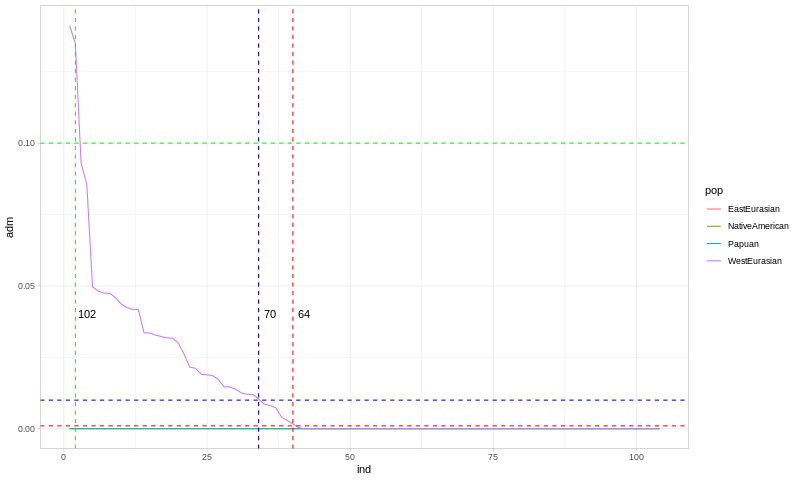

In [27]:
%%R -i admix_in_africans -w 800

admix_in_africans %>%
    gather("pop", "adm", 1:4) %>%
    ggplot() +
    geom_line(aes(x = ind, y = adm, color = pop)) +
    geom_hline(yintercept = 1-0.999, linetype = "dashed", color = "red") +
    geom_vline(xintercept = 40,      linetype = "dashed", color = "red") +
    geom_text(data = data.frame(x = 42, y = 0.04, label = 104-40), aes(x = x, y = y, label = label)) +
    geom_hline(yintercept = 1-0.990, linetype = "dashed", color = "blue") +
    geom_vline(xintercept = 34,      linetype = "dashed", color = "blue") +
    geom_text(data = data.frame(x = 36, y = 0.04, label = 104-34), aes(x = x, y = y, label = label)) +
    geom_hline(yintercept = 1-0.900, linetype = "dashed", color = "green") +
    geom_vline(xintercept = 2,      linetype = "dashed", color = "green") +
    geom_text(data = data.frame(x =  4, y = 0.04, label = 104-2), aes(x = x, y = y, label = label)) +
    theme_light()

From the plot above, I decide to be conservative and only take the subset of African individuals with less than 0.001% of admixture from other populations (mainly WestEurasia).

For that, I first check the populations that those individuals belong ot and take the array of sample IDs corresponding to them

In [19]:
unique_populations = []
for x in admix_df[(admix_df["region"] == "AFRICA") & (admix_df["African"] >= 0.999)].sort_values(by="African")["population"].to_numpy():
    if x not in unique_populations:
        unique_populations.append(x)
print(unique_populations)

['Yoruba', 'BantuSouthAfrica', 'Biaka', 'San', 'Mbuti']


In [28]:
outgroup = admix_df[(admix_df["region"] == "AFRICA") & (admix_df["African"] >= 0.999)].sort_values(by="African")["sample"].to_numpy()
outgroup

array(['HGDP00925', 'HGDP01028', 'HGDP00459', 'HGDP00930', 'HGDP01030',
       'HGDP00992', 'HGDP00926', 'HGDP00460', 'HGDP00455', 'HGDP01029',
       'HGDP00939', 'HGDP00984', 'HGDP01033', 'HGDP01090', 'HGDP00454',
       'HGDP01081', 'HGDP00456', 'HGDP00449', 'HGDP00478', 'HGDP00476',
       'HGDP01032', 'HGDP00932', 'HGDP00991', 'HGDP00936', 'HGDP01034',
       'HGDP00474', 'HGDP01036', 'HGDP00982', 'HGDP00987', 'HGDP01035',
       'HGDP00927', 'HGDP00938', 'HGDP00479', 'HGDP00920', 'HGDP00471',
       'HGDP01094', 'HGDP00469', 'HGDP00475', 'HGDP00473', 'HGDP00470',
       'HGDP00458', 'HGDP00452', 'HGDP01031', 'HGDP00940', 'HGDP00464',
       'HGDP00929', 'HGDP00986', 'HGDP00461', 'HGDP00941', 'HGDP00453',
       'HGDP00935', 'HGDP00994', 'HGDP00993', 'HGDP00985', 'HGDP00472',
       'HGDP00450', 'HGDP00463', 'HGDP00466', 'HGDP00467', 'HGDP00933',
       'HGDP01086', 'HGDP00924', 'HGDP00462', 'HGDP00457'], dtype=object)

And then, I find out to which indeces they correspond in the VCF file. 

In [29]:
outgroup_index = np.array([list(callset["22/samples"][:]).index(s) for s in outgroup])
outgroup_index

array([123, 912,  18, 150, 850, 141, 144, 147, 710, 133, 126, 158, 173,
       174, 708, 135, 803, 816, 125, 817, 841, 843, 847, 848, 863, 870,
       876, 886, 887, 894, 805, 124,   1, 121,   3,   7,   8,   9,  11,
        13,  14,  17,  21,  28,  30,  31,  32, 917,  34,  37,  38,  44,
        46,  48,  54,  55,  70,  92, 107, 112, 115, 119,  36, 923])

In [30]:
outgroup_ind = np.array([callset["22/samples"][:][s] for s in outgroup_index])
outgroup_ind

array(['HGDP00925', 'HGDP01028', 'HGDP00459', 'HGDP00930', 'HGDP01030',
       'HGDP00992', 'HGDP00926', 'HGDP00460', 'HGDP00455', 'HGDP01029',
       'HGDP00939', 'HGDP00984', 'HGDP01033', 'HGDP01090', 'HGDP00454',
       'HGDP01081', 'HGDP00456', 'HGDP00449', 'HGDP00478', 'HGDP00476',
       'HGDP01032', 'HGDP00932', 'HGDP00991', 'HGDP00936', 'HGDP01034',
       'HGDP00474', 'HGDP01036', 'HGDP00982', 'HGDP00987', 'HGDP01035',
       'HGDP00927', 'HGDP00938', 'HGDP00479', 'HGDP00920', 'HGDP00471',
       'HGDP01094', 'HGDP00469', 'HGDP00475', 'HGDP00473', 'HGDP00470',
       'HGDP00458', 'HGDP00452', 'HGDP01031', 'HGDP00940', 'HGDP00464',
       'HGDP00929', 'HGDP00986', 'HGDP00461', 'HGDP00941', 'HGDP00453',
       'HGDP00935', 'HGDP00994', 'HGDP00993', 'HGDP00985', 'HGDP00472',
       'HGDP00450', 'HGDP00463', 'HGDP00466', 'HGDP00467', 'HGDP00933',
       'HGDP01086', 'HGDP00924', 'HGDP00462', 'HGDP00457'], dtype='<U9')

#### 2.2.3 Polarize alleles and SNP filtering for ancestral allele called

In the following section I'm going to polarize alleles according to either the chimpanzee or the multiple sequence alignment of multiple primates, both informations included in the VCF.



In [31]:
print(callset["22/variants/AA_ensembl"][:], callset["22/variants/AA_ensembl"][:].shape)
print(callset["22/variants/AA_chimp"][:], callset["22/variants/AA_ensembl"][:].shape)

['' '' '' ... '' '' ''] (1185008,)
['A' 'G' '' ... '' '' ''] (1185008,)


In [32]:
print(np.unique(callset["22/variants/AA_ensembl"][:]))
print(np.unique(callset["22/variants/AA_chimp"][:]))

['' 'A' 'C' 'G' 'T']
['' 'A' 'C' 'G' 'N' 'T']


From all the positions, I'm only going to take care of the ones in callable regions and in biallelic. 

In [33]:
anc_ens_call_bia_arr = callset["22/variants/AA_ensembl"][:][callabl*biallelic]
anc_chi_call_bia_arr = callset["22/variants/AA_chimp"][:][callabl*biallelic]
ref_arr              = callset["22/variants/REF"][:][callabl*biallelic]
alt_arr              = callset["22/variants/ALT"][:][callabl*biallelic, 0]
print("AA Ensmbl = {}\nAA Chimp  = {}\nREF       = {}\nALT       = {}\n".format(anc_ens_call_bia_arr, anc_chi_call_bia_arr, ref_arr, alt_arr))

AA Ensmbl = ['' '' '' ... 'G' 'C' 'C']
AA Chimp  = ['A' 'T' 'C' ... 'G' 'C' 'T']
REF       = ['A' 'T' 'C' ... 'G' 'C' 'C']
ALT       = ['C' 'A' 'T' ... 'A' 'T' 'G']



In [34]:
ens_ref        = sum(anc_ens_call_bia_arr == ref_arr)
ens_alt        = sum(anc_ens_call_bia_arr == alt_arr)
ens_ref_or_alt = sum(((anc_ens_call_bia_arr == ref_arr) + (anc_ens_call_bia_arr == alt_arr)))

chi_ref        = sum(anc_chi_call_bia_arr == ref_arr)
chi_alt        = sum(anc_chi_call_bia_arr == alt_arr)
chi_ref_or_alt = sum(((anc_chi_call_bia_arr == ref_arr) + (anc_chi_call_bia_arr == alt_arr)))

total          = ref_arr.shape[0]

print("ENSMBL")
print("# Ensmbl == REF = {}".format(ens_ref))
print("% Ensmbl == REF = {:.2f}%".format(ens_ref*100/total))
print("# Ensmbl == ALT = {}".format(ens_alt))
print("% Ensmbl == ALT = {:.2f}%".format(ens_alt*100/total))
print("# Ensmbl == REF | Ensmbl == ALT = {}".format(ens_ref_or_alt))
print("% Ensmbl == REF | Ensmbl == ALT = {:.2f}%".format(100*ens_ref_or_alt/total))
print("")
print("CHIMP")
print("# Chimp == REF = {}".format(chi_ref))
print("% Chimp == REF = {:.2f}%".format(chi_ref*100/total))
print("# Chimp == ALT = {}".format(chi_alt))
print("% Chimp == ALT = {:.2f}%".format(chi_alt*100/total))
print("# Chimp == REF  | Chimp == ALT  = {}".format(chi_ref_or_alt))
print("% Chimp == REF  | Chimp == ALT  = {:.2f}%".format(100*chi_ref_or_alt/total))

ENSMBL
# Ensmbl == REF = 323961
% Ensmbl == REF = 91.89%
# Ensmbl == ALT = 17482
% Ensmbl == ALT = 4.96%
# Ensmbl == REF | Ensmbl == ALT = 341443
% Ensmbl == REF | Ensmbl == ALT = 96.85%

CHIMP
# Chimp == REF = 312147
% Chimp == REF = 88.54%
# Chimp == ALT = 23087
% Chimp == ALT = 6.55%
# Chimp == REF  | Chimp == ALT  = 335234
% Chimp == REF  | Chimp == ALT  = 95.09%


From above, we can see that most of the subset of alleles (callable and biallelic) have an ancestral allele annotated (95%) and that Chimp and Ensmbl seem to differ in the same allele for some of the alleles in chromosome 22. Because Laurits used Ensmbl, I'm going to use Ensmbl as well. 

For that, I'm going to add to the SNP level filter, SNPs that don't have an ancestral allele called

In [35]:
ancestral = (callset["22/variants/AA_ensembl"][:] == callset["22/variants/REF"][:]) + (callset["22/variants/AA_ensembl"][:] == callset["22/variants/ALT"][:, 0])
print(callabl*biallelic*ancestral)
np.sum(callabl*biallelic*ancestral)

[False False False ... False False False]


341443

Then, for those SNPs whose alternative allele match with the ancestral allele, I'm going to polarize the genotype array (loaded below) corresponding to their position correctly by constructing the appropiate mapping array to use in the `.map_alleles(mapping)` function.

First I construct a mapping array that would not change anything from the original genotype array.

In [36]:
mapping = np.array([[0, 1]]*(callset["22/variants/AA_ensembl"][:].shape[0]))
mapping

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [37]:
mapping.shape

(1185008, 2)

Then, I identify those positions which the ancestral allele is the same as the alternative allele

In [38]:
ens_eq_alt = (callset["22/variants/AA_ensembl"][:] == callset["22/variants/ALT"][:, 0])
ens_eq_alt

array([False, False, False, ..., False, False, False])

And finally, I flip the mapping of those positions such that I can polarize them correctly. 

In [39]:
mapping[ens_eq_alt, 0] = 1
mapping[ens_eq_alt, 1] = 0
print("reversed\n", mapping[ens_eq_alt], "\nsame\n", mapping[~ens_eq_alt])

reversed
 [[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]] 
same
 [[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


Now it's time to load the genotype array. 

In [40]:
gt = allel.GenotypeArray(callset["22/calldata/GT"])
gt

<GenotypeArray shape=(1185008, 929, 2) dtype=int8>
./. 0/0 0/0 ./. ./. ... ./. ./. ./. ./. ./.
./. 0/0 0/0 ./. ./. ... ./. ./. ./. ./. ./.
./. 0/0 0/0 ./. ./. ... ./. ./. ./. ./. ./.
...
./. ./. ./. ./. ./. ... ./. 0/0 0/0 ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.

We can visualize some of the positions where ALT == ANC

In [41]:
gt[ens_eq_alt]

<GenotypeArray shape=(47249, 929, 2) dtype=int8>
./. ./. ./. ./. 0/0 ... ./. ./. ./. ./. ./.
./. 0/0 0/0 0/0 0/0 ... ./. 0/0 ./. ./. 0/0
./. 0/0 0/0 0/0 0/0 ... ./. 0/0 ./. ./. ./.
...
./. ./. 0/0 0/0 ./. ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 1/1 0/0 ./. 0/0 ... 0/0 0/0 0/0 0/0 0/0

And check how they look like after polarization

In [42]:
gt_pol = gt.map_alleles(mapping)
gt_pol[ens_eq_alt]

<GenotypeArray shape=(47249, 929, 2) dtype=int8>
./. ./. ./. ./. 1/1 ... ./. ./. ./. ./. ./.
./. 1/1 1/1 1/1 1/1 ... ./. 1/1 ./. ./. 1/1
./. 1/1 1/1 1/1 1/1 ... ./. 1/1 ./. ./. ./.
...
./. ./. 1/1 1/1 ./. ... 1/1 1/1 1/1 1/1 1/1
1/1 1/1 1/1 1/0 1/1 ... 1/1 1/1 1/1 1/1 1/1
1/1 0/0 1/1 ./. 1/1 ... 1/1 1/1 1/1 1/1 1/1

So, it works as expected. 

We can finally, from the polarized genotype array, subset:
- SNPs
    - In callable regions (acessibility + non-repetitive)
    - Biallelic (defined above)
    - Have the ancestral allele called
- Individuals
    - African individuals with less than 0.1% admixture from WestEurasia

### 2.2.4 Polymorphic sites in the outgroup and mutation rate file

In [48]:
gt_outgroup = gt_pol.compress(callabl*biallelic*ancestral, axis = 0).take(outgroup_index, axis = 1)
gt_outgroup

<GenotypeArray shape=(341443, 64, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/1 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [51]:
np.sum(gt_outgroup.count_alleles().is_segregating())

129048

Also, subset the genomic position of the loci that we extracted in the genotype array by applying the same filters

In [52]:
ps_outgroup = allel.SortedIndex(callset['22/variants/POS']).compress(callabl*biallelic*ancestral)
ps_outgroup

0,1,2,3,4,...,341438,341439,341440,341441,341442
16159718,16159740,16159764,16159856,16159879,...,50747861,50754611,50755017,50773329,50775215


The function `.count_alleles()` counts the alleles of each type in a genotype array.

In [53]:
gt_outgroup_allele_count = gt_outgroup.count_alleles()
gt_outgroup_allele_count

<AlleleCountsArray shape=(341443, 2) dtype=int32>
128   0
126   2
128   0
...
119   7
126   0
128   0

This is perfect for me because here I'm looking for polymorphic positions, so none of the alleles must be fixes (following the instructions of Skov et al, specifically the code `Estimate_mutationrate.py`)

In [54]:
polymorphic_loci = (gt_outgroup_allele_count[:, 0] != 0)*(gt_outgroup_allele_count[:, 1] != 0)
polymorphic_loci

array([False,  True, False, ...,  True, False, False])

Then, I can use the file `chr22_weigths.txt` in which there are the windows of the genome (1kb) with the callability (done above). From that, I can extract the first two columns as start and stop positions for...

In [76]:
weigths = np.loadtxt("/home/moicoll/GenerationInterval/people/moi/tmp/weigths/chr22_weigths.txt", usecols=[1, 2, 3])
weigths

array([[0.0000e+00, 1.0000e+03, 0.0000e+00],
       [1.0000e+03, 2.0000e+03, 0.0000e+00],
       [2.0000e+03, 3.0000e+03, 0.0000e+00],
       ...,
       [5.1303e+07, 5.1304e+07, 0.0000e+00],
       [5.1304e+07, 5.1305e+07, 0.0000e+00],
       [5.1305e+07, 5.1306e+07, 0.0000e+00]])

In [78]:
np.array([weigths[:, 0]+1, weigths[:, 1]]).T

array([[1.0000000e+00, 1.0000000e+03],
       [1.0010000e+03, 2.0000000e+03],
       [2.0010000e+03, 3.0000000e+03],
       ...,
       [5.1303001e+07, 5.1304000e+07],
       [5.1304001e+07, 5.1305000e+07],
       [5.1305001e+07, 5.1306000e+07]])

the function `allel.windowed_statistic()`, which calculates an statistic in specified windows. In this case, since I want to calculate the number of polymorphic sites in windows of 1kb, I only need to use the function `np.sum` onto the `polymorphic_loci` function which contains for each position (`ps_outgroup`) if it is considered as polymorphic or not. 

In [79]:
snp_count, windows, _ = allel.windowed_statistic(pos = ps_outgroup, values = polymorphic_loci, statistic = np.sum, windows = np.array([weigths[:, 0]+1, weigths[:, 1]]).T,  fill = 0)
print(snp_count)
print(windows)

[0 0 0 ... 0 0 0]
[[1.0000000e+00 1.0000000e+03]
 [1.0010000e+03 2.0000000e+03]
 [2.0010000e+03 3.0000000e+03]
 ...
 [5.1303001e+07 5.1304000e+07]
 [5.1304001e+07 5.1305000e+07]
 [5.1305001e+07 5.1306000e+07]]


Finally, we can use the information that is contained in this "weigths" file which is the callability for each window to create a dataframe...

In [80]:
mut_rate = np.array([windows[:, 0]-1, windows[:, 1], snp_count, weigths[:, 2]]).T
mut_rate

array([[0.0000e+00, 1.0000e+03, 0.0000e+00, 0.0000e+00],
       [1.0000e+03, 2.0000e+03, 0.0000e+00, 0.0000e+00],
       [2.0000e+03, 3.0000e+03, 0.0000e+00, 0.0000e+00],
       ...,
       [5.1303e+07, 5.1304e+07, 0.0000e+00, 0.0000e+00],
       [5.1304e+07, 5.1305e+07, 0.0000e+00, 0.0000e+00],
       [5.1305e+07, 5.1306e+07, 0.0000e+00, 0.0000e+00]])

In [81]:
mut_rate_df = pd.DataFrame(data=mut_rate, columns=["start", "end", "segregating", "call"])
mut_rate_df[mut_rate_df["start"] > 27000000]

,start,end,segregating,call
27001,27001000.0,27002000.0,1.0,0.251
27002,27002000.0,27003000.0,4.0,0.265
27003,27003000.0,27004000.0,11.0,0.903
27004,27004000.0,27005000.0,7.0,0.497
27005,27005000.0,27006000.0,0.0,0.168
...,...,...,...,...
51301,51301000.0,51302000.0,0.0,0.000
51302,51302000.0,51303000.0,0.0,0.000
51303,51303000.0,51304000.0,0.0,0.000
51304,51304000.0,51305000.0,0.0,0.000


and compute the mutation rate (segregating sites / callable sites). Following the instructions in Skov et al git hub, I also calculated that as the mean over 1Mb. So, instead of calculating for each 1kb window the mutation rate as segregating sites / callable sites, I add up all the segregating sites and callable bases in 1000 of those windows (1Mb in total) and calculate the mutation rate. Thus, the mutation rate value is going to be the same for every 1000 lines. This is done because the measurment of local mutation rate is very noisy. 

Instead of the absolute measurement, I want the relative measure comapred to the mean mutation rate of the whole chromosome. Thus, I divide each mutation rate calculation by the genomic mutation rate.

I want to clarify that to obtain a value for each row (with the `.apply` pandas function) I had to call a value of each row in the equation, otherwise I would only get a value for each group created. That is why I get the "start" value, divide it by the same (start/start = 1) and multiply this by the mutation rate calculation. 

In [82]:
genomic_mut_rate = np.sum(mut_rate_df["segregating"])/np.sum(mut_rate_df["call"])

mut_rate_df["mut_rate"] = (mut_rate_df.assign(start_big_window = (mut_rate_df["start"]/1000000).astype(int))
                            .groupby("start_big_window", group_keys=False)
                            .apply(lambda x : ((x["start"]+1)/(x["start"]+1)) *  np.sum(x["segregating"])/np.sum(x["call"]) / genomic_mut_rate  )
                            .fillna(0))

mut_rate_df[27000:28001]

,start,end,segregating,call,mut_rate
27000,27000000.0,27001000.0,2.0,0.489,1.009325
27001,27001000.0,27002000.0,1.0,0.251,1.009325
27002,27002000.0,27003000.0,4.0,0.265,1.009325
27003,27003000.0,27004000.0,11.0,0.903,1.009325
27004,27004000.0,27005000.0,7.0,0.497,1.009325
...,...,...,...,...,...
27996,27996000.0,27997000.0,6.0,1.000,1.009325
27997,27997000.0,27998000.0,6.0,1.000,1.009325
27998,27998000.0,27999000.0,4.0,0.897,1.009325
27999,27999000.0,28000000.0,5.0,0.764,1.009325


Here is a plot of the mutation rate profile along the genome.

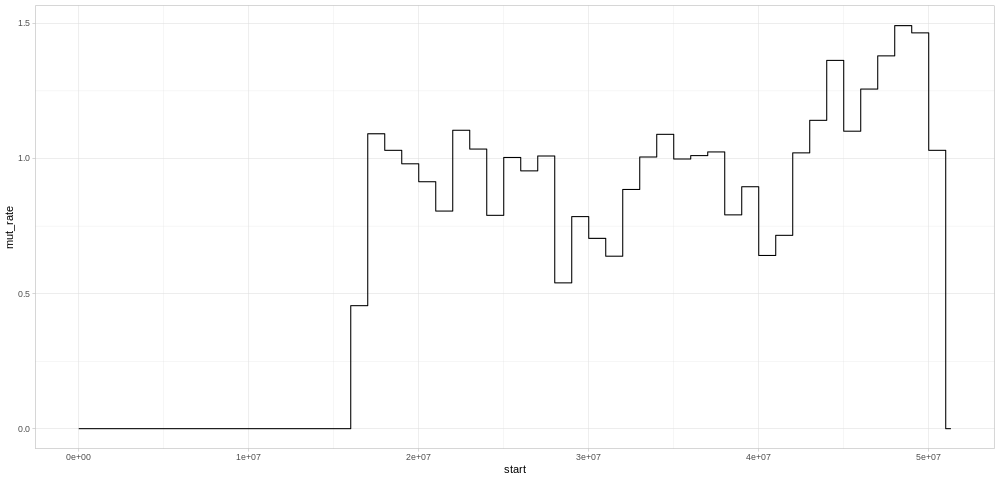

In [83]:
%%R -i mut_rate_df -w 1000

mut_rate_df %>%
    ggplot() +
    geom_line(aes(x = start, y = mut_rate)) +
    theme_light()

I finally output the dataframe created into a file.

In [42]:
(mut_rate_df.drop(["segregating", "call"], axis = 1)
            .astype({"start": int, "end": int})
            .to_csv("/home/moicoll/GenerationInterval/people/moi/tmp/mut_rate/22.mut", sep="\t", header=False, index=False))

NameError: name 'mut_rate_df' is not defined

### 1000 Genomes Project African outgroups

In [61]:
outgroup_1KGP = (pd.read_csv("/home/moicoll/1000GP/data/igsr-1000genomes30xongrch38_samples.tsv", sep = "\t")
                         .filter(["Sample name", "Population code", "Superpopulation code"])
                         .rename(columns = {"Sample name" : "sample", "Population code" : "pop", "Superpopulation code" : "reg"})
                         .query('pop in ["ESN", "YRI", "MSL"]')
                         .filter(["sample"])).to_numpy().reshape(-1).tolist()

outgroup_1KGP[:5]

['HG02922', 'HG02941', 'HG02946', 'HG02953', 'HG02965']

In [63]:
zarr_path_1KGP = '/home/moicoll/GenerationInterval/people/moi/tmp/zarr/1KGP/20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr22.recalibrated_variants.zarr'

callset_1KGP = zarr.open_group(zarr_path_1KGP, mode='r')
print(callset_1KGP.tree(expand=True))

/
 └── 22
     ├── calldata
     │   ├── AB (1927372, 3202) float32
     │   ├── AD (1927372, 3202, 7) int16
     │   ├── DP (1927372, 3202) int16
     │   ├── GQ (1927372, 3202) int8
     │   ├── GT (1927372, 3202, 2) int8
     │   ├── MIN_DP (1927372, 3202) int32
     │   ├── MQ0 (1927372, 3202) int16
     │   ├── PGT (1927372, 3202) object
     │   ├── PID (1927372, 3202) object
     │   ├── PL (1927372, 3202, 3) int32
     │   ├── RGQ (1927372, 3202) int32
     │   └── SB (1927372, 3202, 4) int32
     ├── samples (3202,) object
     └── variants
         ├── AC (1927372, 6) int32
         ├── AC_AFR (1927372, 6) int32
         ├── AC_AFR_unrel (1927372, 6) int32
         ├── AC_AMR (1927372, 6) int32
         ├── AC_AMR_unrel (1927372, 6) int32
         ├── AC_EAS (1927372, 6) int32
         ├── AC_EAS_unrel (1927372, 6) int32
         ├── AC_EUR (1927372, 6) int32
         ├── AC_EUR_unrel (1927372, 6) int32
         ├── AC_Het (1927372, 6) int32
         ├── AC_Het_AFR (1927372, 

In [70]:
outgroup_1KGP_idx = [i for i in range(callset_1KGP["22/samples"].shape[0]) if callset_1KGP["22/samples"][i] in outgroup_1KGP]
outgroup_1KGP_idx[:5]

[1457, 1458, 1459, 1460, 1461]

In [77]:
callset_1KGP["22/variants/POS"][:10]

array([10510061, 10510077, 10510103, 10510105, 10510119, 10510169,
       10510183, 10510212, 10510292, 10510352], dtype=int32)

In [81]:
loc1, loc2 = allel.SortedIndex(callset_1KGP["22/variants/POS"][:10]).locate_intersection(allel.SortedIndex(callset_1KGP["22/variants/POS"][5:17]))
print(loc1)
loc2

[False False False False False  True  True  True  True  True]


array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False])

In [86]:
a = allel.SortedIndex(callset_1KGP["22/variants/POS"][5:17])[loc2] > 10510212
a

array([False, False, False,  True,  True])

In [87]:
loc1

array([False, False, False, False, False,  True,  True,  True,  True,
        True])

In [88]:
loc1[loc1] = allel.SortedIndex(callset_1KGP["22/variants/POS"][5:17])[loc2] > 10510212

In [89]:
loc1

array([False, False, False, False, False, False, False, False,  True,
        True])

In [75]:
(allel.GenotypeDaskArray(callset_1KGP["22/calldata/GT"])
                         .take(outgroup_1KGP_idx, axis = 1)
                         .count_alleles()
                         .is_variant()
                         .compute())

array([False, False, False, ...,  True, False,  True])

[<img src="notebooks_files/arrow.png" width="100" style="float: left;">](#Ho) &nbsp;

&nbsp;

### 2.2.5 Observation file for one individual

To obtain the observation file for each individual, I first select the individuals in the "ingroup".

In [85]:
ingroup = admix_df[(admix_df["region"] != "AFRICA")]["sample"].to_numpy()
ingroup[:10]

array(['HGDP01189', 'HGDP01368', 'HGDP01216', 'HGDP01244', 'HGDP01243',
       'HGDP01299', 'HGDP00845', 'HGDP00135', 'HGDP00214', 'HGDP00655'],
      dtype=object)

And obtain the indeces.

In [86]:
ingroup_index = np.array([list(callset["22/samples"][:]).index(s) for s in ingroup])
ingroup_index[:10]

array([ 6, 10, 24, 33, 41, 42, 43, 50, 51, 52])

In the next chunk I check that the first two indeces are correct. 

In [87]:
for i, x in enumerate(callset["22/samples"][:][:11]):
    print(i, x)

0 HGDP01201
1 HGDP00479
2 HGDP01408
3 HGDP00471
4 HGDP01411
5 HGDP00937
6 HGDP01189
7 HGDP01094
8 HGDP00469
9 HGDP00475
10 HGDP01368


Then, I remove all SNPs from the genotype array which any of the outgroup individuals have a derived allele. 

In [57]:
anc_in_outgroup = (gt_outgroup_allele_count[:, 0] > 0)*(gt_outgroup_allele_count[:, 1] == 0)
print(anc_in_outgroup.shape)
print(np.sum(anc_in_outgroup))
anc_in_outgroup

(341443,)
210122


array([ True, False,  True, ..., False,  True,  True])

And similarly as before, I obtain the genotype array with only the ingroup individuals filtering all SNPs that:
1. Are in callable regions
2. Are biallelic
3. Have the ancestral state called
4. Any of the outgroup individuals has a derived allele

In [198]:
gt_ingroup = gt_pol.compress(callabl*biallelic*ancestral, axis = 0).take(ingroup_index, axis = 1)#.compress(anc_in_outgroup, axis = 0)
gt_ingroup

<GenotypeArray shape=(341443, 825, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

I obtain the genomic position of the SNPs in the genotype array I just created

In [193]:
ps_ingroup = allel.SortedIndex(callset['22/variants/POS']).compress(callabl*biallelic*ancestral)#.compress(anc_in_outgroup)
ps_ingroup

0,1,2,3,4,...,341438,341439,341440,341441,341442
16159718,16159740,16159764,16159856,16159879,...,50747861,50754611,50755017,50773329,50775215


Now, I select the first individual, and obtain the genotypes (from the genotype array) and check those positions in which the individual has a derived allele.

In [91]:
ind_der = np.sum(gt_ingroup[:, 0], axis = 1) > 0

In [141]:
np.sum(ind_der)

1450

In [92]:
ps_ind_der = ps_ingroup[ind_der]
ps_ind_der

0,1,2,3,4,...,1445,1446,1447,1448,1449
16600150,16604350,16615974,16637857,16722213,...,50577502,50641766,50656498,50678082,50710565


As in the previous section, I use the weigths file to obtain the starting and ending positions of each window. 

In [93]:
np.array([weigths[:, 0]+1, weigths[:, 1]]).T

array([[1.0000000e+00, 1.0000000e+03],
       [1.0010000e+03, 2.0000000e+03],
       [2.0010000e+03, 3.0000000e+03],
       ...,
       [5.1303001e+07, 5.1304000e+07],
       [5.1304001e+07, 5.1305000e+07],
       [5.1305001e+07, 5.1306000e+07]])

Then, I construct a function that counts the number of positions for which the individual has at least a derived allele and the genomic positions of those loci. 

In [111]:
ps_ind_der.intersect_range(16600150, 16722213)

0,1,2,3,4
16600150,16604350,16615974,16637857,16722213


In [162]:
def obs_per_ind(start, stop):
    obs = ps_ind_der.intersect_range(start, stop)
    return np.array(len(obs)), ",".join([str(snp) for snp in obs])

vec_obs_per_ind = np.vectorize(obs_per_ind)

n_obs, pos_obs = vec_obs_per_ind(weigths[:, 0]+1, weigths[:, 1])

obs = pd.DataFrame({"start" : weigths[:, 0].astype(int), 
                    "end"   : weigths[:, 1].astype(int), 
                    "n_obs" : n_obs.astype(int), 
                    "snps"  : pos_obs})
obs

,start,end,n_obs,snps
0,0,1000,0,
1,1000,2000,0,
2,2000,3000,0,
3,3000,4000,0,
4,4000,5000,0,
...,...,...,...,...
51301,51301000,51302000,0,
51302,51302000,51303000,0,
51303,51303000,51304000,0,
51304,51304000,51305000,0,


Then, to inspect the dataframe created, I show the counts of windows with x n_obs loci and plot the genomic position vs n_obs of this first individual. 

In [95]:
%%R -i obs

obs %>%
    count(n_obs)

  n_obs     n
1     0 49938
2     1  1293
3     2    69
4     3     5
5     4     1


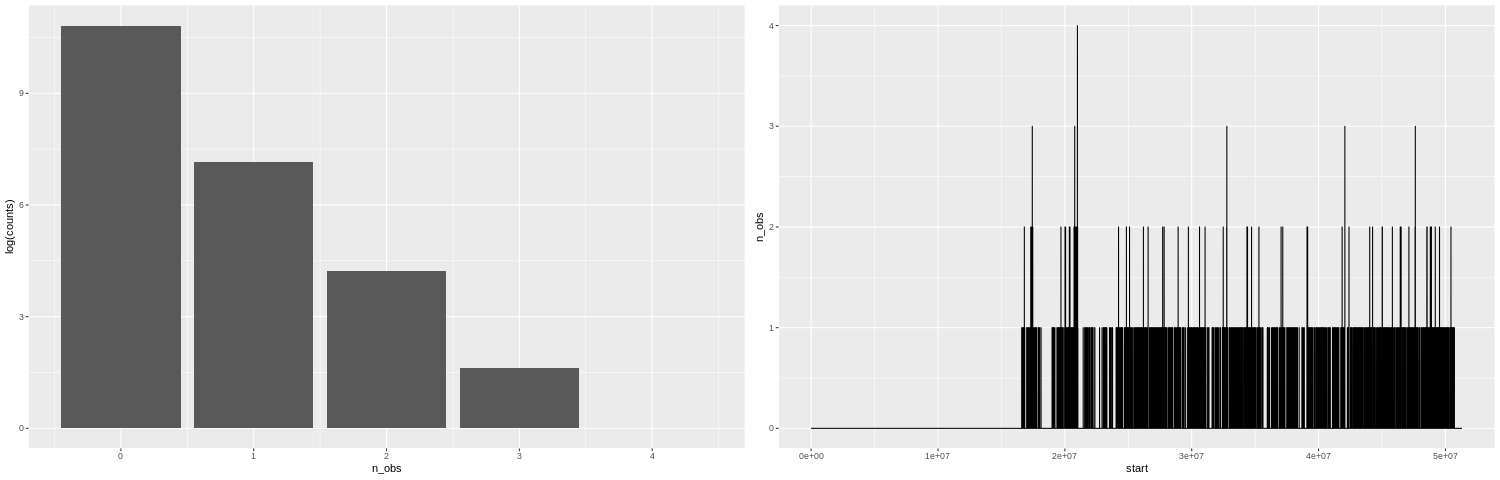

In [96]:
%%R -i obs -w 1500


plot_grid(
obs %>%
    count(n_obs) %>%
    mutate(n = log(n)) %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = n_obs, y = n)) +
    ylab("log(counts)"),
    
obs %>%
    ggplot() +
    geom_line(aes(x = start, y = n_obs)))
    

Finally, I save the dataframe into a file. 

In [97]:
obs.to_csv("/home/moicoll/GenerationInterval/people/moi/tmp/obs/{}.obs".format(callset["22/samples"][ingroup_index[0]]), sep = "\t", header=False, index=False)

[<img src="notebooks_files/arrow.png" width="100" style="float: left;">](#Ho) &nbsp;

&nbsp;

<a name="Hmm"></a>
## 3. Training and Decoding

First, I'll check that all necessary files have the right number of rows as suggested by Laurits in his github page.

In [28]:
%%bash
head ../../tmp/obs/HGDP00001.observations.txt
wc -l ../../tmp/obs/HGDP00001.observations.txt

1	0	0	
1	1000	0	
1	2000	0	
1	3000	0	
1	4000	0	
1	5000	0	
1	6000	0	
1	7000	0	
1	8000	0	
1	9000	0	
2881066 ../../tmp/obs/HGDP00001.observations.txt


In [27]:
%%bash
head ../../tmp/weigths/weigths.txt
wc -l ../../tmp/weigths/weigths.txt

chr1	0	0
chr1	1000	0
chr1	2000	0
chr1	3000	0
chr1	4000	0
chr1	5000	0
chr1	6000	0
chr1	7000	0
chr1	8000	0
chr1	9000	0
2881066 ../../tmp/weigths/weigths.txt


In [29]:
%%bash
head ../../tmp/mutrate/mutrate.txt
wc -l ../../tmp/mutrate/mutrate.txt

1	0	1.5089142988959081
1	1000	1.5089142988959081
1	2000	1.5089142988959081
1	3000	1.5089142988959081
1	4000	1.5089142988959081
1	5000	1.5089142988959081
1	6000	1.5089142988959081
1	7000	1.5089142988959081
1	8000	1.5089142988959081
1	9000	1.5089142988959081
2881066 ../../tmp/mutrate/mutrate.txt


Then, I automate the whole pipeline in `workflow.py`

When running it, I got the following error for these individuals

- HGDP00545
- HGDP01207
- HGDP00043
- HGDP00185
- HGDP00675
- HGDP00171
- HGDP00887

This is because `np.log()` function can't handle a number as big as `math.factorial(21)`

In [31]:
np.log(math.factorial(20))

42.335616460753485

In [32]:
np.log(math.factorial(21))

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log method

a solution can be to code it in a small function in python

In [7]:
def log_factorial(x):
    total = 0
    for y in range(1,x+1):
        total += np.log(y)
    return total
        
print(log_factorial(5), np.log(math.factorial(5)))


4.787491742782046 4.787491742782046


Then, I check for those individuals that the pipeline failed, if they have more than 20 SNPs in one window. 

In [25]:
%%bash

for ind in HGDP00545 HGDP01207 HGDP00043 HGDP00185 HGDP00675 HGDP00171 HGDP00887;
do
    echo ${ind}
    awk '{if($3 > 20){print}}' ../../tmp/obs/${ind}.observations.txt 
    echo "#############################"
    echo ""
done


HGDP00545
8	60938000	21	60938017,60938039,60938085,60938088,60938089,60938112,60938144,60938211,60938222,60938328,60938356,60938363,60938416,60938448,60938485,60938505,60938530,60938543,60938627,60938654,60938675
#############################

HGDP01207
1	219928000	28	219928570,219928571,219928574,219928588,219928599,219928621,219928622,219928645,219928723,219928742,219928745,219928746,219928749,219928775,219928780,219928821,219928830,219928831,219928835,219928865,219928894,219928902,219928904,219928948,219928949,219928951,219928959,219928961
#############################

HGDP00043
22	22918000	23	22918217,22918278,22918279,22918281,22918289,22918291,22918319,22918320,22918325,22918353,22918360,22918514,22918515,22918521,22918528,22918561,22918562,22918566,22918588,22918616,22918627,22918675,22918684
#############################

HGDP00185
22	22098000	22	22098026,22098196,22098213,22098221,22098246,22098296,22098324,22098344,22098348,22098362,22098363,22098370,22098405,22098671,220987

So, I can see that there are some windows for certain individuals that have more than 20 SNPs for a single window. To bypass this problem, I'm going to create an if statement that ensures that the maximum number of observations is 20 when calculating `np.log(math.factorial(x))`

Below, I show some metadata for those individuals, but I don't see soemthing that differenciate them from the rest (admixture with other populations, contamination (freemix) or coverage)

In [36]:
pd.read_csv("/home/moicoll/HGDP/data/admixture/k5-ancestry.hgdp.v0.5.mask2.ascertain-archaics.regions.txt", sep = "\t").query('sample in ["HGDP00545","HGDP01207","HGDP00043","HGDP00185","HGDP00675","HGDP00171","HGDP00887"]')
                                                                                                                               
                                                                                                                               

,sample,population,region,Papuan,NativeAmerican,African,WestEurasian,EastEurasian
108,HGDP00545,PapuanSepik,OCEANIA,0.999960,0.000010,0.000010,0.000010,0.000010
243,HGDP01207,Oroqen,EAST_ASIA,0.000010,0.052379,0.000010,0.024591,0.923010
352,HGDP00043,Brahui,CENTRAL_SOUTH_ASIA,0.001089,0.019124,0.028907,0.868602,0.082279
368,HGDP00185,Sindhi,CENTRAL_SOUTH_ASIA,0.002898,0.043164,0.000010,0.820873,0.133055
516,HGDP00675,Palestinian,MIDDLE_EAST,0.000010,0.000010,0.050629,0.949341,0.000010
701,HGDP00171,Sindhi,CENTRAL_SOUTH_ASIA,0.006229,0.035202,0.000010,0.802386,0.156173
883,HGDP00887,Russian,EUROPE,0.000010,0.042728,0.000010,0.887894,0.069358


In [37]:
pd.read_csv("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", sep = "\t").query('sample in ["HGDP00545","HGDP01207","HGDP00043","HGDP00185","HGDP00675","HGDP00171","HGDP00887"]')
                                                                                                                               
        

,sample,library,sample_accession,source,library_type,population,latitude,longitude,region,sex,coverage,freemix,capmq,insert_size_average,array_non_reference_discordance
21,HGDP00043,HGDP00043.15458927,ERS474528,sanger,PCRfree,Brahui,30.5,66.5,CENTRAL_SOUTH_ASIA,M,33.44,0.01093,20,430.2,0.066006
97,HGDP00171,HGDP00171.15458885,ERS474464,sanger,PCRfree,Sindhi,25.5,69.0,CENTRAL_SOUTH_ASIA,M,35.54,0.00980,20,433.4,0.055155
104,HGDP00185,HGDP00185.15458969,ERS474471,sanger,PCRfree,Sindhi,25.5,69.0,CENTRAL_SOUTH_ASIA,M,30.71,0.01556,20,418.6,0.095842
248,HGDP00545,HGDP00545.11144818,ERS474917,sanger,PCR,PapuanSepik,-4.0,143.0,OCEANIA,M,32.57,0.00196,27,512.3,0.059496
364,HGDP00675,HGDP00675.15775119,ERS474780,sanger,PCRfree,Palestinian,32.0,35.0,MIDDLE_EAST,M,39.80,0.00837,21,451.1,0.050867
531,HGDP00887,HGDP00887.LP6005441-DNA_G10,ERS1042231,sgdp,PCRfree,Russian,61.0,40.0,EUROPE,M,39.72,0.00134,28,333.3,0.449520
742,HGDP01207,HGDP01207.15362760,ERS474310,sanger,PCRfree,Oroqen,50.4,126.5,EAST_ASIA,M,30.28,0.01610,20,455.9,0.118563


In [40]:
(pd.read_csv("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", sep = "\t").query('sample in ["HGDP00545","HGDP01207","HGDP00043","HGDP00185","HGDP00675","HGDP00171","HGDP00887"]')["freemix"]
    .to_numpy()
    .mean())
                                                                                                                               
        

0.00915142857142857

In [41]:
(pd.read_csv("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", sep = "\t").query('sample not in ["HGDP00545","HGDP01207","HGDP00043","HGDP00185","HGDP00675","HGDP00171","HGDP00887"]')["freemix"]
    .to_numpy()
    .mean())

0.007345455531453362

In [42]:
(pd.read_csv("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", sep = "\t").query('sample not in ["HGDP00545","HGDP01207","HGDP00043","HGDP00185","HGDP00675","HGDP00171","HGDP00887"]')["freemix"]
    .to_numpy()
    .max())

0.02506

## RESULTS

In [7]:
%%R

read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>%
    group_by(population, region) %>%
    summarize(n = n()) %>%
    arrange(region, population) 

`summarise()` regrouping output by 'population' (override with `.groups` argument)
# A tibble: 54 x 3
# Groups:   population [54]
   population       region      n
   <fct>            <fct>   <int>
 1 BantuKenya       AFRICA     11
 2 BantuSouthAfrica AFRICA      8
 3 Biaka            AFRICA     22
 4 Mandenka         AFRICA     22
 5 Mbuti            AFRICA     13
 6 San              AFRICA      6
 7 Yoruba           AFRICA     22
 8 Colombian        AMERICA     7
 9 Karitiana        AMERICA    12
10 Maya             AMERICA    21
# … with 44 more rows


In [8]:
%%R

read.table("/home/moicoll/GenerationTime/faststorage/02MutationProfile/files/ind_pop_region_sex_correctsex.txt", col.names = c("sample", "population", "region", "sex")) %>%
    filter("B_" != str_sub(sample, 0, 2)) %>%
    group_by(population, region) %>%
    summarize(n = n()) %>%
    arrange(region, population) %>%
    ungroup() 

`summarise()` regrouping output by 'population' (override with `.groups` argument)
# A tibble: 135 x 3
   population    region     n
   <fct>         <fct>  <int>
 1 BantuHerero   Africa     2
 2 BantuKenya    Africa     2
 3 BantuTswana   Africa     2
 4 Biaka         Africa     2
 5 Dinka         Africa     2
 6 Esan          Africa     2
 7 Gambian       Africa     2
 8 Ju_hoan_North Africa     3
 9 Khomani_San   Africa     2
10 Luhya         Africa     2
# … with 125 more rows


`summarise()` regrouping output by 'population' (override with `.groups` argument)


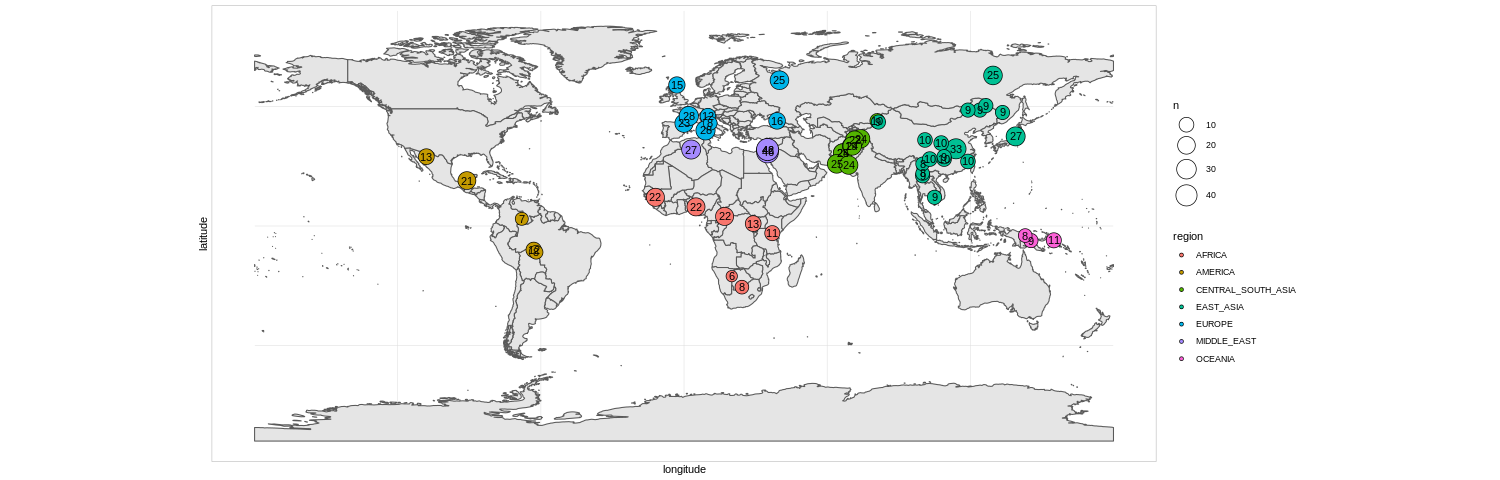

In [56]:
%%R -w 1500

world <- ne_countries(scale = "medium", returnclass = "sf")

read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>%
    group_by(population, region) %>%
    summarize(n = n(), longitude = mean(longitude), latitude = mean (latitude)) %>%
    ggplot() +
    geom_sf(data = world) +
    geom_point(aes(x = longitude, y = latitude, fill = region, size = n), shape = 21) +
    geom_text(aes(x = longitude, y = latitude, label = n)) +
    scale_size(range = c(5, 10))

`summarise()` regrouping output by 'population' (override with `.groups` argument)


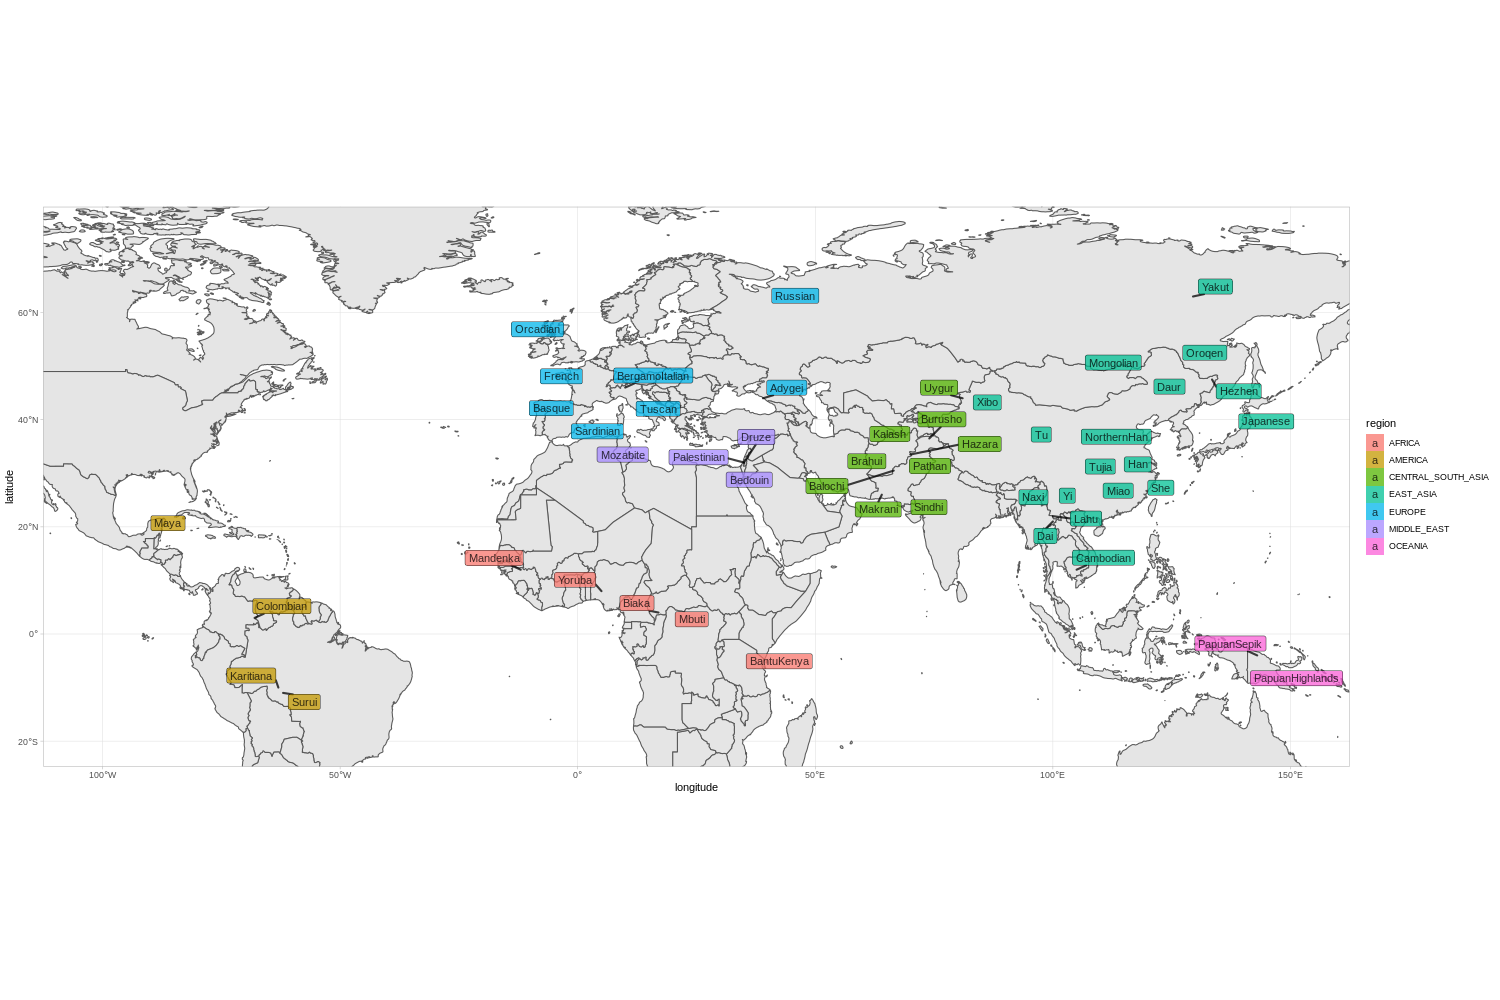

In [54]:
%%R -w 1500 -h 1000

world <- ne_countries(scale = "medium", returnclass = "sf")

read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>%
    group_by(population, region) %>%
    summarize(n = n(), longitude = mean(longitude), latitude = mean (latitude)) %>%
    ggplot() +
    geom_sf(data = world) +
    geom_label_repel(aes(x = longitude, y = latitude, label = population, fill = region), alpha = 0.75, segment.size = 1) +
    scale_size(range = c(5, 10)) +
    xlim(c(-100, 150)) +
    ylim(c(-20, 75))

In [12]:
%%R

read.table("/home/moicoll/GenerationInterval/people/moi/tmp/dec/ArchaicFragments.txt", header = TRUE) %>% 
    group_by(ind) %>%
    summarize(mean_len = mean(len), median_len = median(len), max_len = max(len), min_len = min(len), n_frag = n(), total_seq = sum(len)) -> arch_frag

`summarise()` ungrouping output (override with `.groups` argument)


In [50]:
%%R 

arch_frag %>% 
    head()

# A tibble: 6 x 7
  ind       mean_len median_len max_len min_len n_frag total_seq
  <fct>        <dbl>      <dbl>   <int>   <int>  <int>     <int>
1 HGDP00001   66654.      41000  776000    1000   2016 134374000
2 HGDP00003   62621.      40000 1065000    1000   2164 135511000
3 HGDP00005   65280.      41000  822000    1000   2122 138525000
4 HGDP00007   66358.      41000  822000    1000   1959 129995000
5 HGDP00009   63511.      39000  991000    1000   2078 131976000
6 HGDP00011   63835.      41000  986000    1000   2123 135521000


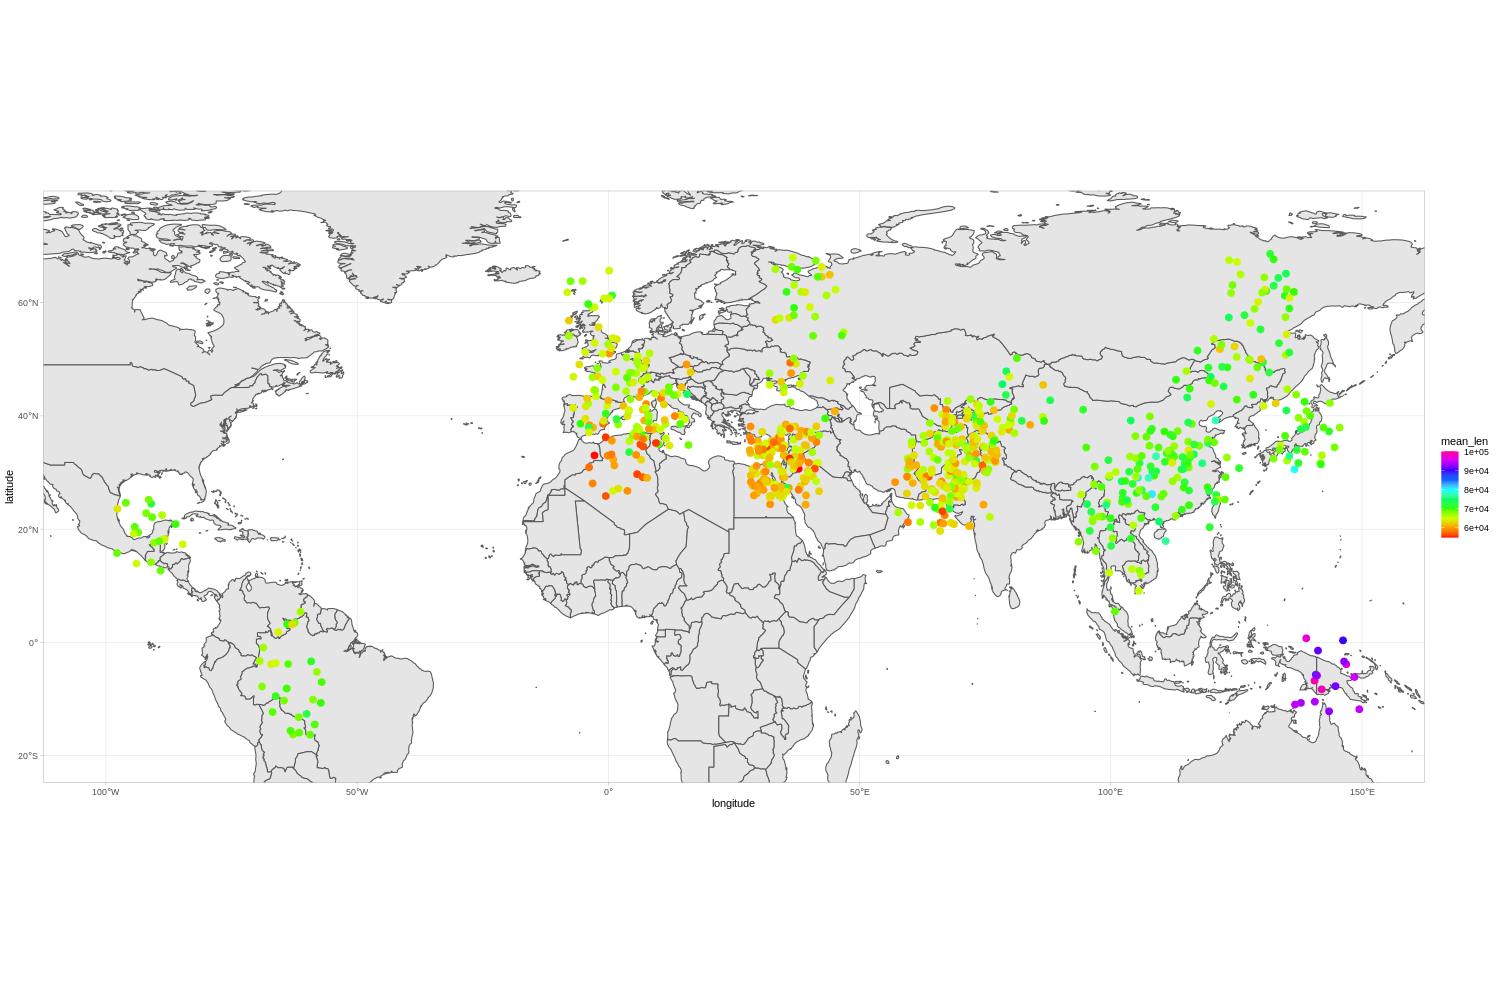

In [25]:
%%R -w 1500 -h 1000

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region), by = c("ind")) %>% 
    #filter(region != "OCEANIA") %>%
    ggplot() +
    geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
    geom_jitter(aes(x = longitude, y = latitude, color = mean_len), width = 7, height = 7, size = 3) +
    scale_colour_gradientn(colors = rainbow(10)) +
    xlim(c(-100, 150)) +
    ylim(c(-20, 75))

`summarise()` ungrouping output (override with `.groups` argument)


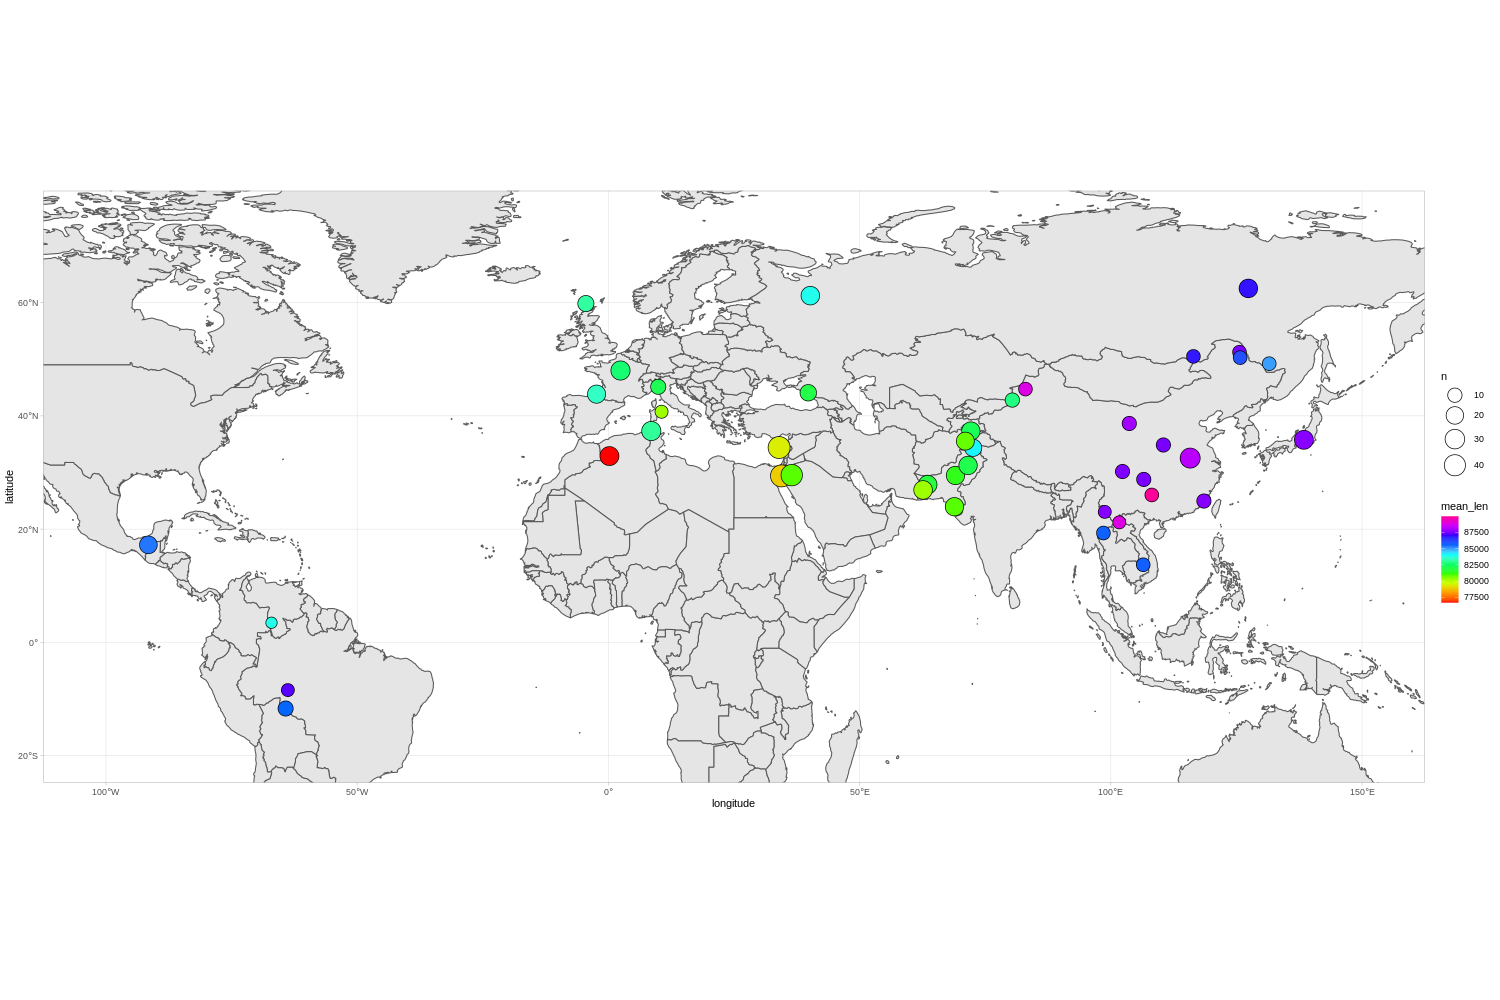

In [80]:
%%R -w 1500 -h 1000

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region, population), by = c("ind")) %>% 
    group_by(population) %>%
    filter(region != "OCEANIA") %>%
    summarize(mean_len = mean(mean_len), latitude = mean(latitude), longitude = mean(longitude), n = n()) %>%
    
    ggplot() +
    geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
    geom_jitter(aes(x = longitude, y = latitude, fill = mean_len, size = n), width = 3, height = 3, shape = 21) +
    scale_fill_gradientn(colors = rainbow(10)) +
    xlim(c(-100, 150)) +
    ylim(c(-20, 75)) +
    scale_size(range = c(5, 10))

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


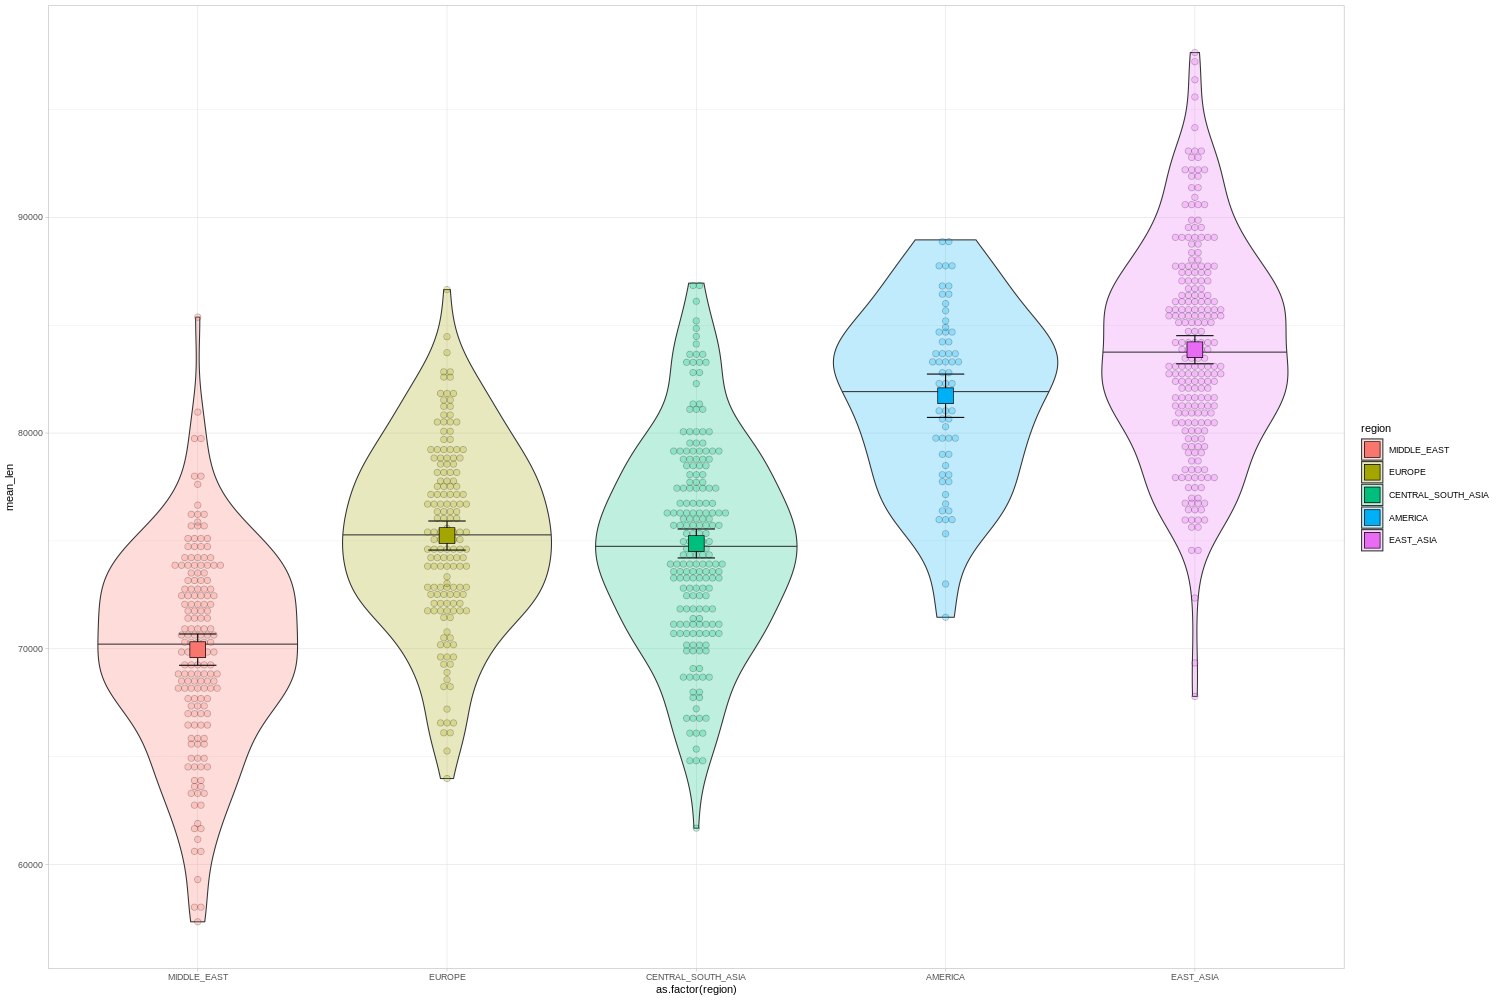

In [10]:
%%R -w 1500 -h 1000

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region), by = c("ind")) %>% 
    mutate(region = factor(region, levels = c("MIDDLE_EAST", "EUROPE", "CENTRAL_SOUTH_ASIA", "AMERICA", "EAST_ASIA", "OCEANIA"))) %>%
    filter(region != "OCEANIA") %>%
    ggplot() +
    geom_violin(aes(x = as.factor(region), y = mean_len, fill = region), alpha = 0.25, draw_quantiles = c(0.5)) +
    geom_dotplot(aes(x = as.factor(region), y = mean_len, fill = region), binaxis = "y", stackdir = "center", binwidth = 300, alpha = 0.25) +
    geom_errorbar(data = . %>% group_by(region) %>% summarize(mean_mean_len = mean(mean_len), sd_len = sd(mean_len), n = n()) %>% mutate(se = sd_len/sqrt(n)), 
                  aes(x = as.factor(region), ymin = mean_mean_len-(1.96*se), ymax = mean_mean_len+(1.96*se)), width = 0.15) +
    geom_point(data = . %>% group_by(region) %>% summarize(mean_len = mean(mean_len)), aes(x = region, y = mean_len, fill = region), shape = 22, size = 8) 

In [11]:
%%R

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region), by = c("ind")) %>% 
    group_by(region) %>% 
    summarize(mean_n_frag = mean(n_frag), mean_total_seq = mean(total_seq), mean_mean_len = mean(mean_len), sd_len = sd(mean_len), n = n()) %>% 
    mutate(se = sd_len/sqrt(n)) %>%
    arrange(mean_mean_len)

`summarise()` ungrouping output (override with `.groups` argument)
# A tibble: 6 x 7
  region             mean_n_frag mean_total_seq mean_mean_len sd_len     n    se
  <fct>                    <dbl>          <dbl>         <dbl>  <dbl> <int> <dbl>
1 MIDDLE_EAST              1587.     125571161.        79214.  2849.   161  225.
2 CENTRAL_SOUTH_ASIA       1634.     133392315.        81690.  3088.   197  220.
3 EUROPE                   1550.     128407497.        82874.  3067.   155  246.
4 AMERICA                  1591.     137031607.        86168.  2528.    61  324.
5 EAST_ASIA                1677.     146582359.        87451.  3029.   223  203.
6 OCEANIA                  2050.     231929643.       113208.  3140.    28  593.


`summarise()` regrouping output by 'region' (override with `.groups` argument)


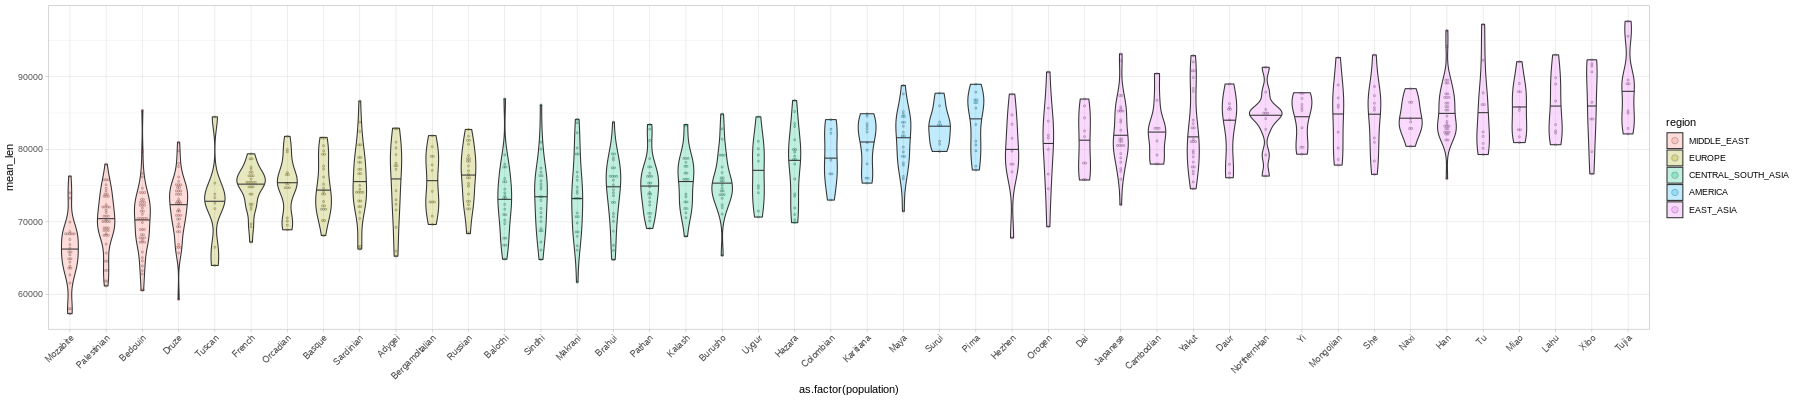

In [28]:
%%R -w 1800 -h 400

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region, population), by = c("ind")) %>% 
    mutate(region = factor(region, levels = c("MIDDLE_EAST", "EUROPE", "CENTRAL_SOUTH_ASIA", "AMERICA", "EAST_ASIA", "OCEANIA"))) %>%
    group_by(region, population) %>%
    summarize(mean_len_mean = mean(mean_len)) %>%
    arrange(region, mean_len_mean) %>%
    pull(population) -> population_order

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region, population), by = c("ind")) %>% 
    mutate(region = factor(region, levels = c("MIDDLE_EAST", "EUROPE", "CENTRAL_SOUTH_ASIA", "AMERICA", "EAST_ASIA", "OCEANIA")),
           population = factor(population, levels = population_order)) %>%
    filter(region != "OCEANIA") %>%
    ggplot() +
    geom_violin(aes(x = as.factor(population), y = mean_len, fill = region, group = population), alpha = 0.25, draw_quantiles = c(0.5)) +
    geom_dotplot(aes(x = as.factor(population), y = mean_len, fill = region, group = population), binaxis = "y", stackdir = "center", binwidth = 300, alpha = 0.25) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

`summarise()` regrouping output by 'region' (override with `.groups` argument)


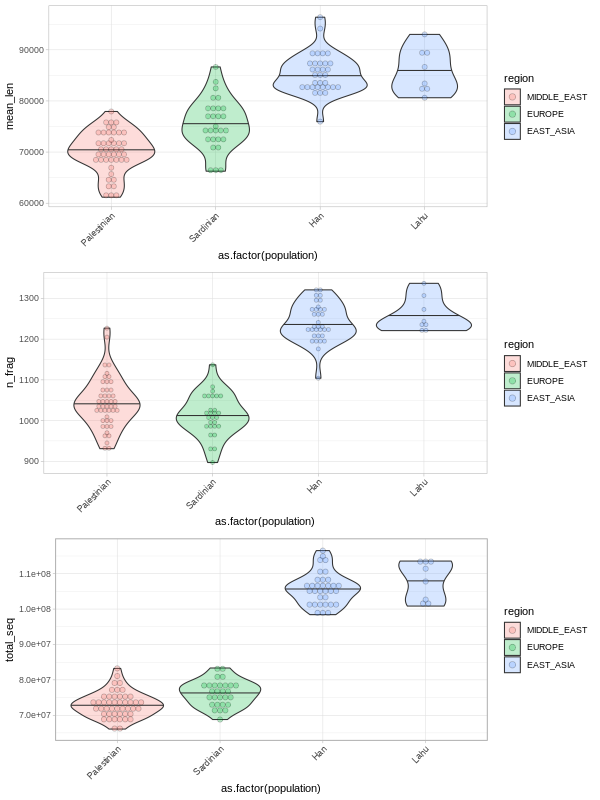

In [13]:
%%R -w 600 -h 800

arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region, population), by = c("ind")) %>% 
    mutate(region = factor(region, levels = c("MIDDLE_EAST", "EUROPE", "CENTRAL_SOUTH_ASIA", "AMERICA", "EAST_ASIA", "OCEANIA"))) %>%
    group_by(region, population) %>%
    summarize(mean_len_mean = mean(mean_len)) %>%
    arrange(region, mean_len_mean) %>%
    pull(population) -> population_order
    
arch_frag %>% 
    left_join(read.table("/home/moicoll/HGDP/data/metadata/hgdp_wgs.20190516.metadata.txt", header = T) %>% 
                    select(ind = sample, population, latitude, longitude, region, population), by = c("ind")) %>% 
    mutate(region = factor(region, levels = c("MIDDLE_EAST", "EUROPE", "CENTRAL_SOUTH_ASIA", "AMERICA", "EAST_ASIA", "OCEANIA")),
           population = factor(population, levels = population_order)) %>%
    filter(region != "OCEANIA") %>%
    filter(population %in% c("Palestinian", "Sardinian", "Lahu", "Han")) -> fourpop_df

plot_grid(
    
fourpop_df %>%
    ggplot() +
    geom_violin(aes(x = as.factor(population), y = mean_len, fill = region, group = population), alpha = 0.25, draw_quantiles = c(0.5)) +
    geom_dotplot(aes(x = as.factor(population), y = mean_len, fill = region, group = population), binaxis = "y", stackdir = "center", binwidth = 1000, alpha = 0.25) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)),
    
fourpop_df %>%
    ggplot() +
    geom_violin(aes(x = as.factor(population), y = n_frag, fill = region, group = population), alpha = 0.25, draw_quantiles = c(0.5)) +
    geom_dotplot(aes(x = as.factor(population), y = n_frag, fill = region, group = population), binaxis = "y", stackdir = "center", binwidth = 10, alpha = 0.25) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)),

fourpop_df %>%
    ggplot() +
    geom_violin(aes(x = as.factor(population), y = total_seq, fill = region, group = population), alpha = 0.25, draw_quantiles = c(0.5)) +
    geom_dotplot(aes(x = as.factor(population), y = total_seq, fill = region, group = population), binaxis = "y", stackdir = "center", binwidth = 1500000, alpha = 0.25) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)), ncol = 1)
    

In [22]:
%%R

fourpop_df %>%
    select(population, mean_len, n_frag, total_seq) %>%
    gather("stat", "value", mean_len, n_frag, total_seq) %>%
    group_by(population, stat) %>%
    summarize(mean = mean(value), sd = sd(value)) %>%
    gather("measure", "value", mean, sd) %>%
    unite("stat", stat, measure, sep = "_") %>%
    spread(stat, value) %>%
    select(total_seq_sd)
    

`summarise()` regrouping output by 'population' (override with `.groups` argument)
Adding missing grouping variables: `population`
# A tibble: 4 x 2
# Groups:   population [4]
  population  total_seq_sd
  <fct>              <dbl>
1 Palestinian     3644923.
2 Sardinian       3624999.
3 Han             4611438.
4 Lahu            5480052.


In [27]:
%%R

read.table("/home/moicoll/GenerationTime/faststorage/02MutationProfile/plots/Generation_time_mutation_profile_Jupyter-notebook/github_derived_alleles/Data1_archaicfragments.txt", header = T) %>%
    filter(region %in% c("WestEurasia", "EastAsia")) %>%
    group_by(name, region) %>%
    summarize(mean_len = mean(length), n_frag = n(), total_seq = sum(length)) %>%
    ungroup() %>%
    gather("stat", "value", mean_len, n_frag, total_seq) %>%
    group_by(region, stat) %>%
    summarize(mean = mean(value), sd = sd(value)) %>%
    gather("measure", "value", mean, sd) %>%
    unite("stat", stat, measure, sep = "_") %>%
    spread(stat, value) %>%
    select(total_seq_sd)

`summarise()` regrouping output by 'name' (override with `.groups` argument)
`summarise()` regrouping output by 'region' (override with `.groups` argument)
Adding missing grouping variables: `region`
# A tibble: 2 x 2
# Groups:   region [2]
  region      total_seq_sd
  <fct>              <dbl>
1 EastAsia        4820292.
2 WestEurasia     6332052.


`summarise()` regrouping output by 'name', 'pop' (override with `.groups` argument)
`summarise()` regrouping output by 'pop' (override with `.groups` argument)
`summarise()` regrouping output by 'name', 'pop' (override with `.groups` argument)


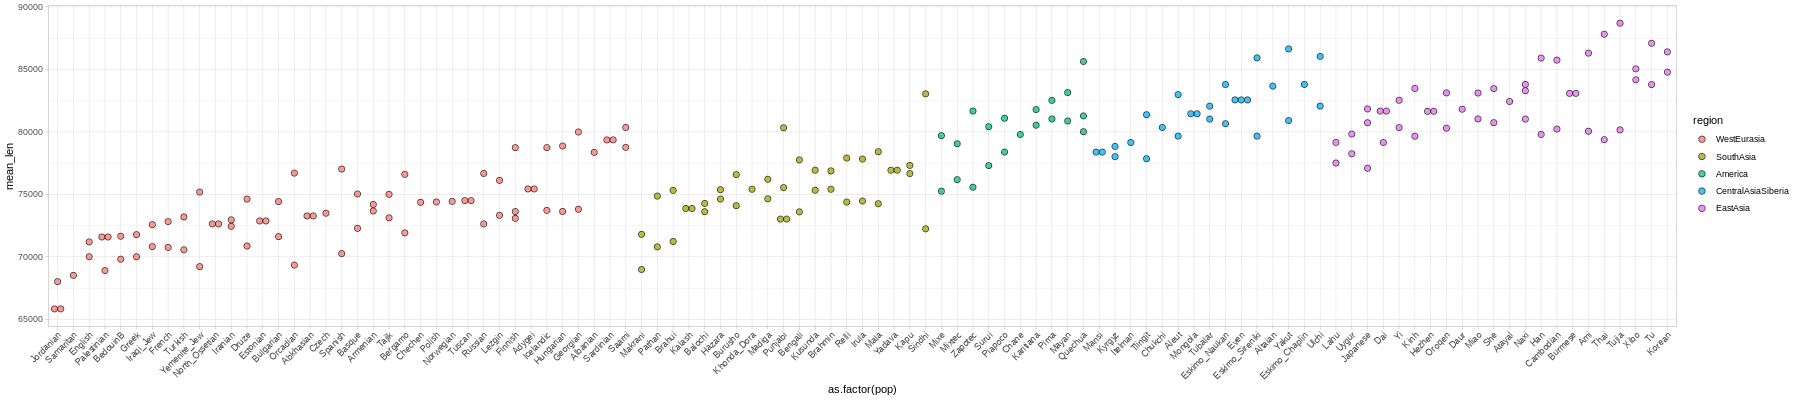

In [25]:
%%R -w 1800 -h 400

read.table("/home/moicoll/GenerationTime/faststorage/02MutationProfile/plots/Generation_time_mutation_profile_Jupyter-notebook/github_derived_alleles/Data1_archaicfragments.txt", header = T) %>%
    filter(region %in% c(                     "WestEurasia", "SouthAsia", "America", "CentralAsiaSiberia", "EastAsia")) %>%
    mutate(region = factor(region, levels = c("WestEurasia", "SouthAsia", "America", "CentralAsiaSiberia", "EastAsia"))) %>%
    mutate(pop = gsub("^S_", "", name)) %>% 
    mutate(pop = gsub("-[0-9]*", "", pop)) %>% 
    group_by(name, pop, region) %>%
    summarize(mean_len = mean(length)) %>%  
    ungroup() %>%
    group_by(pop, region) %>%
    summarize(mean_len_mean = mean(mean_len)) %>%
    ungroup() %>%
    arrange(region, mean_len_mean) %>%
    pull(pop) -> population_order
    
read.table("/home/moicoll/GenerationTime/faststorage/02MutationProfile/plots/Generation_time_mutation_profile_Jupyter-notebook/github_derived_alleles/Data1_archaicfragments.txt", header = T) %>%
    filter(region %in% c(                     "WestEurasia", "SouthAsia", "America", "CentralAsiaSiberia", "EastAsia")) %>%
    mutate(region = factor(region, levels = c("WestEurasia", "SouthAsia", "America", "CentralAsiaSiberia", "EastAsia"))) %>%
    mutate(pop = gsub("^S_", "", name)) %>% 
    mutate(pop = gsub("-[0-9]*", "", pop)) %>% 
    group_by(name, pop, region) %>%
    summarize(mean_len = mean(length)) %>% 
    ungroup() %>%
    mutate(pop = factor(pop, levels = population_order)) %>% 
    ggplot() +
#     geom_violin(aes(x = as.factor(pop), y = mean_len, fill = region, group = pop), alpha = 0.25, draw_quantiles = c(0.5)) +
    geom_dotplot(aes(x = as.factor(pop), y = mean_len, fill = region, group = pop), binaxis = "y", stackdir = "center", binwidth = 500, alpha = 0.75) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [30]:
%%R

read.table("/home/moicoll/GenerationTime/faststorage/02MutationProfile/plots/Generation_time_mutation_profile_Jupyter-notebook/github_derived_alleles/Data1_archaicfragments.txt", header = T) %>%
    filter(region %in% c(                     "WestEurasia", "SouthAsia", "America", "CentralAsiaSiberia", "EastAsia")) %>%
    mutate(region = factor(region, levels = c("WestEurasia", "SouthAsia", "America", "CentralAsiaSiberia", "EastAsia"))) %>%
    mutate(pop = gsub("^S_", "", name)) %>% 
    mutate(pop = gsub("-[0-9]*", "", pop)) %>% 
    group_by(name, pop, region) %>%
    summarize(mean_len = mean(length)) %>%  
    ungroup() %>%
    group_by(pop, region) %>%
    summarize(mean_len_mean = mean(mean_len)) %>%
    ungroup() %>%
    arrange(region, mean_len_mean) %>%
    filter(pop %in% c("Sardinian", "Lahu"))

`summarise()` regrouping output by 'name', 'pop' (override with `.groups` argument)
`summarise()` regrouping output by 'pop' (override with `.groups` argument)
# A tibble: 2 x 3
  pop       region      mean_len_mean
  <chr>     <fct>               <dbl>
1 Sardinian WestEurasia        79355.
2 Lahu      EastAsia           78330.


In [19]:
#3
def two_group_diff(df):
    '''
    - Input:
        - df  : pandas Dataframe with two columns:
            - group : the values for which the data is going to be distributed in groups
            - value : values for which the difference between the groups' means is going to be computed
    - Output:
        - difference between the group means
    '''
    means = df.groupby('group', as_index=False, group_keys=False)["value"].agg('mean')
    return means["value"][1] - means["value"][0]

#4
def permutation_two_group_diff(df, n_perm = 100000):
    '''
    - Input:
        - df  : pandas Dataframe with two columns:
            - group : the values for which the data is going to be distributed in groups
            - value : values for which the difference between the groups' means is going to be computed
    - Output:
        - diffobs : observed difference between the means of the two groups
        - p       : number of permutations with the same difference value or more extreme than the obseved (diffobs)
    '''
    diffobs = two_group_diff(df)
    p       = 0
    for i in range(n_perm):
        shuffled = pd.DataFrame({"group" : df["group"], "value" : np.random.permutation(df["value"].values)})
        if two_group_diff(shuffled) >= diffobs:
            p += 1

    return diffobs, min(p, n_perm-p)

In [17]:
fourpop_df_pd = %R fourpop_df %>% select(population, mean_len) %>% rename(group = population, value = mean_len) %>% mutate(group = as.character(group))
fourpop_df_pd

,group,value
1,Sardinian,71985.074627
2,Sardinian,78259.701493
3,Sardinian,78956.696878
4,Sardinian,77378.669276
5,Sardinian,74207.119741
...,...,...
111,Lahu,83404.549147
112,Lahu,89845.161290
113,Lahu,82525.368249
114,Lahu,82217.845659


In [21]:
for twopop in [["Sardinian", "Palestinian"], ["Lahu", "Han"], ["Sardinian", "Lahu"]]:
    pop1, pop2 = twopop
    fourpop_df_pd_2pop = fourpop_df_pd.query('group in ["{}", "{}"]'.format(pop1, pop2))
    diffobs, p = permutation_two_group_diff(fourpop_df_pd_2pop, n_perm = 100000)
    print("{}\t{}\t{}\t{}\t{}".format(pop1, pop2, diffobs, p, p*2/100000))

Sardinian	Palestinian	5391.261317702578	0	0.0
Lahu	Han	553.4791046633618	35557	0.71114
Sardinian	Lahu	-10439.848711947096	1	2e-05
